# **Analysis of Restaurant Network: The Explainer Notebook**
A deep dive into the dynamics, structure, and connectivity of a network of restaurants.

# Table of Contents
1. [Motivation](#Motivation)
    - [Project Motivation](#Motivation)
    - [Dataset Motivation](#Motivation)
2. [Data Cleaning & Preprocessing](#Data-Cleaning-and-Preprocessing)
3. [Simple Network Analytics](#Simple-Network-Analytics)
4. [Network Analysis (Communities & Clustering)](#Network-Analysis-(Communities-&-Clustering))
5. [Sentiment Text Analysis](#Sentiment-Text-Analysis)
7. [Combining Community Analysis with Sentiment Scores](#Combining-Community-Analysis-with-Sentiment-Scores)
8. [Discussion](#Discussion)
9. [Contributions](#Contributions)

This notebook serves as a behind-the-scenes explanation of our project. It is meant to be read as a supplement to our analysis of restaurant networks and sentiment text review analysis across various cities, as detailed in our paper. The notebook provides additional technical insights for those curious about the methods and data processing steps. However, it is not necessary to read this notebook to understand the main analysis.

To run this notebook, ensure that all libraries listed below are installed and loaded on your machine.

**OBS: Some code snippets are also outcommented due to the plots (WordClouds and Maps) taking too much memory and space.**

In [2]:
import pandas as pd
import networkx as nx
import pickle
import json
from collections import defaultdict, Counter
import community as community_louvain
import numpy as np
import matplotlib.pyplot as plt
from fa2_modified import ForceAtlas2
from tqdm import tqdm
import random
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud, STOPWORDS
from cuisines_scrap import cuisine_scrap
import folium
import matplotlib
import seaborn as sns
from scipy.stats import kruskal
import kagglehub
import os
import shutil

C:\Users\victo\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Download the Data (with Kagglehub import)

In [2]:
path = kagglehub.dataset_download("fahadsyed97/restaurant-reviews")
print("Path to dataset files:", path)

current_path = os.getcwd()

data_folder = os.path.join(current_path, "data")

os.makedirs(data_folder, exist_ok=True)

for item in os.listdir(path):
    source = os.path.join(path, item)
    destination = os.path.join(data_folder, item)
    if os.path.isdir(source):
        shutil.move(source, destination)
    else:
        shutil.move(source, destination)

print(f"Files moved to: {os.path.abspath(data_folder)}")

100%|████████████████████████████████████████████████████████████████████████| 2.04G/2.04G [01:01<00:00, 35.7MB/s]

Extracting files...


Path to dataset files: /Users/danieljalel/.cache/kagglehub/datasets/fahadsyed97/restaurant-reviews/versions/1
Files moved to: /Users/danieljalel/Desktop/02805/RestaurantNetwork/data


# ...Or Download the Data Manually

**If you want to download the data manually then you need to do the following steps!**

1. Download the data from the URL: [https://www.kaggle.com/datasets/fahadsyed97/restaurant-reviews](https://www.kaggle.com/datasets/fahadsyed97/restaurant-reviews)
2. Create a folder in the root of the GitHub repo directory called 'data'
3. Add the .csv file 'precovid_reviews.csv' into the 'data' folder.

# Motivation

## Project Motivation
Understanding customer satisfaction and behavior in the restaurant industry is an exciting and important topic. This project focuses on analyzing a network of restaurants to explore how customer sentiment, as reflected in reviews, is related to the type of cuisine or the city where the restaurant is located. We think this is a fascinating way to uncover patterns and trends in how people interact with restaurants and share their dining experiences.

In this project, we aim to address three main research questions:

1. **Community Detection**: Do users tend to review similar types of cuisines, or do they review restaurants across different cities? Can we uncover patterns in the restaurant network based on these factors?
2. **Sentiment Analysis**: Can we link customer sentiment in reviews to specific types of cuisines or cities? Are there noticeable differences in satisfaction based on the cuisine or the location of a restaurant?
3. **Combining Sentiment and Community Detection**: How do average sentiment scores vary across the identified clusters or communities of restaurants? Are there specific clusters (based on cities or cuisines) that consistently show higher or lower sentiment scores?
 
By analyzing sentiment and clustering patterns, we hope to gain a deeper understanding of restaurant networks and customer behavior, bridging the gap between dining preferences and network dynamics.

## Dataset Motivation
The dataset used for this project is a Kaggle dataset created by Fahad Syed ([link](https://www.kaggle.com/datasets/fahadsyed97/restaurant-reviews)), containing over 5 million restaurant reviews. We chose this dataset because it is not only large but also comprehensive, including everything we need to address our research questions. The dataset provides detailed information about each review, such as the date of the review, the restaurant’s business_id, name, location (latitude, longitude, city, postal code), and the text of the review itself.

We believe this dataset is perfect for our analysis as it allows us to approach the problem from multiple angles. It gives us the opportunity to perform sentiment analysis to measure customer satisfaction and to analyze network patterns based on cities and cuisines. With this dataset, we have all the information we need to explore the relationship between customer behavior and restaurant characteristics in a detailed and meaningful way.

# Data Cleaning and Preprocessing

**Removing old entries**: Since the dataset is extremely huge, we should only focus on the latest data. The latest years in the dataset are of restaurant reviews from 2018 and 2019. We will remove entries older than 2018.

**Removing closed restaurant entries**: We will remove entries in the dataset with restaurants that are closed. There is a binary (1 or 0) column that tells whether or not the restaurant is open or not.

In [3]:
input_file_path = 'data/precovid_reviews.csv'

# The new filtered CSV file
output_file_path = 'filtered_reviews_open2018_2019.csv'

# Chunk size for faster processing
chunk_size = 10000

total_rows = 0

with open(output_file_path, 'w', encoding='utf-8') as output_file: 
    for chunk in tqdm(pd.read_csv(input_file_path, chunksize=chunk_size)):
        # Converting the 'date_' column to datetime
        chunk['date_'] = pd.to_datetime(chunk['date_'], errors='coerce')

        # Filtering rows 
        filtered_chunk = chunk[(chunk['is_open'] == 1) & (chunk['date_'].dt.year.isin([2018, 2019]))]

        # Updating the total row counter for debugging and data size overview
        total_rows += len(filtered_chunk)

        filtered_chunk.to_csv(output_file, index=False, mode='a', header=output_file.tell() == 0, encoding='utf-8')  # Write header only for the first chunk

print(f"Number of rows in the filtered dataset: {total_rows}")

518it [01:53,  4.56it/s]

Number of rows in the filtered dataset: 1206983


We create the graph from the filtered dataset.

In [4]:
file_path = 'filtered_reviews_open2018_2019.csv'

G = nx.Graph()

chunk_size = 10000

for chunk in tqdm(pd.read_csv(file_path, usecols=['business_id', 'user_id'], chunksize=chunk_size)):
    # Iterating over each user ('user_id')
    for user_id, group in chunk.groupby('user_id'):
        # Getting a list of business_id's that the user reviewed
        businesses = group['business_id'].tolist()

        # Connecting each business_id (restaurant) that the user reviewed to every other business they also reviewed
        for i in range(len(businesses)):
            for j in range(i + 1, len(businesses)):
                business_a = businesses[i]
                business_b = businesses[j]
                
                # Adding an edge between the two businesses
                G.add_edge(business_a, business_b)

num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

print(f"Number of restaurants (nodes): {num_nodes}")
print(f"Number of connections (edges): {num_edges}")

# Saving the graph for future use
with open('business_graph.pkl', 'wb') as f:
    pickle.dump(G, f)

121it [00:59,  2.04it/s]

Number of restaurants (nodes): 21009
Number of connections (edges): 53837


With this filtering, we now have approximately 21K nodes and 53K edges, which is still quite large. To further refine the network, we decided to apply an additional filtering step by **analyzing the degree distribution and selecting an appropriate threshold**.

We start by plotting the count of nodes and links against the degree threshold.

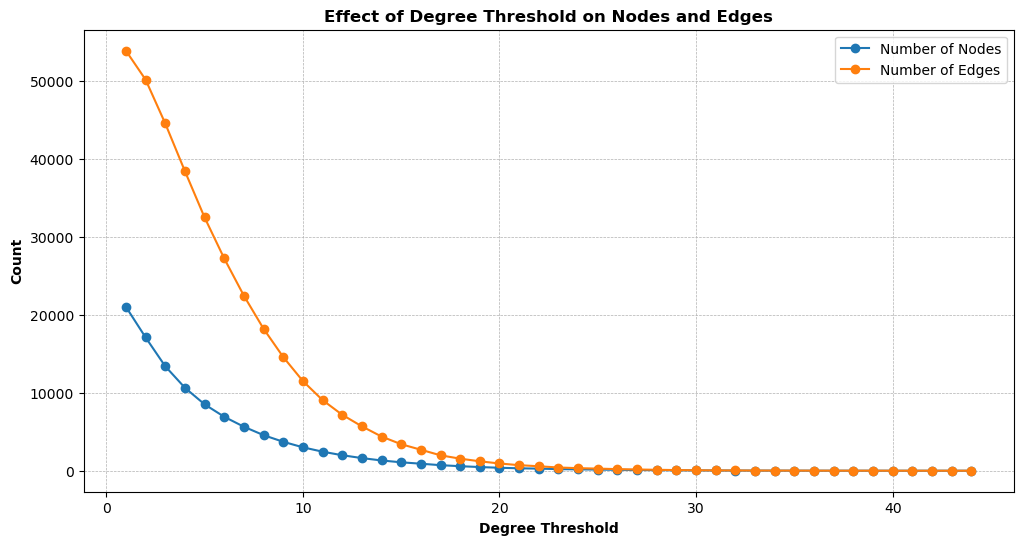

In [5]:
with open('business_graph.pkl', 'rb') as f:
    G = pickle.load(f)

# Initializing lists to store the number of nodes and edges for different thresholds
thresholds = range(1, 45) 
num_nodes = []
num_edges = []

# Computing nodes and edges for each threshold
for threshold in thresholds:
    # Filtering nodes with degree >= threshold
    filtered_nodes = [node for node, degree in G.degree() if degree >= threshold]
    G_filtered = G.subgraph(filtered_nodes)
    
    num_nodes.append(G_filtered.number_of_nodes())
    num_edges.append(G_filtered.number_of_edges())

# Plotting the results 
plt.figure(figsize=(12, 6))
plt.plot(thresholds, num_nodes, marker='o', label='Number of Nodes')
plt.plot(thresholds, num_edges, marker='o', label='Number of Edges')
plt.title("Effect of Degree Threshold on Nodes and Edges", fontweight='bold')
plt.xlabel("Degree Threshold", fontweight='bold')
plt.ylabel("Count", fontweight='bold')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

Based on the plot above, we chose a **degree threshold of 5**. 

This is suitable as we want to remove most low-degree nodes while retaining a reasonably sized network for our analysis. At this point, the number of edges is still substantial, and the core structure of the network remains intact.

Next, we want to **validate our choice of degree threshold by examining the trade-off between the average clustering coefficient and preserving the largest connected component**.

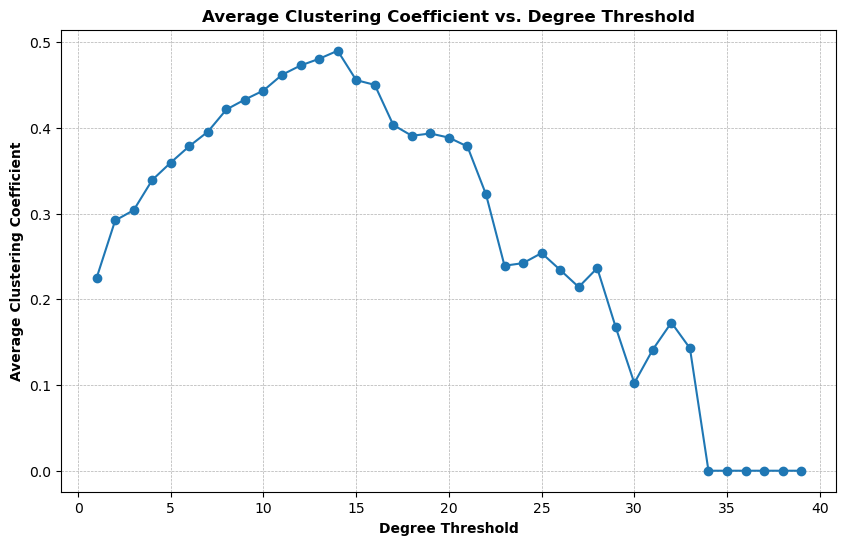

In [6]:
thresholds = range(1, 40) 
average_clustering = []

# Computing the average clustering coefficient for each threshold
for threshold in thresholds:
    filtered_nodes = [node for node, degree in G.degree() if degree >= threshold]
    G_filtered = G.subgraph(filtered_nodes)
    
    # Calculating the average clustering coefficient
    avg_clustering = nx.average_clustering(G_filtered)
    average_clustering.append(avg_clustering)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(thresholds, average_clustering, marker='o')
plt.title("Average Clustering Coefficient vs. Degree Threshold", fontweight='bold')
plt.xlabel("Degree Threshold", fontweight='bold')
plt.ylabel("Average Clustering Coefficient", fontweight='bold')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

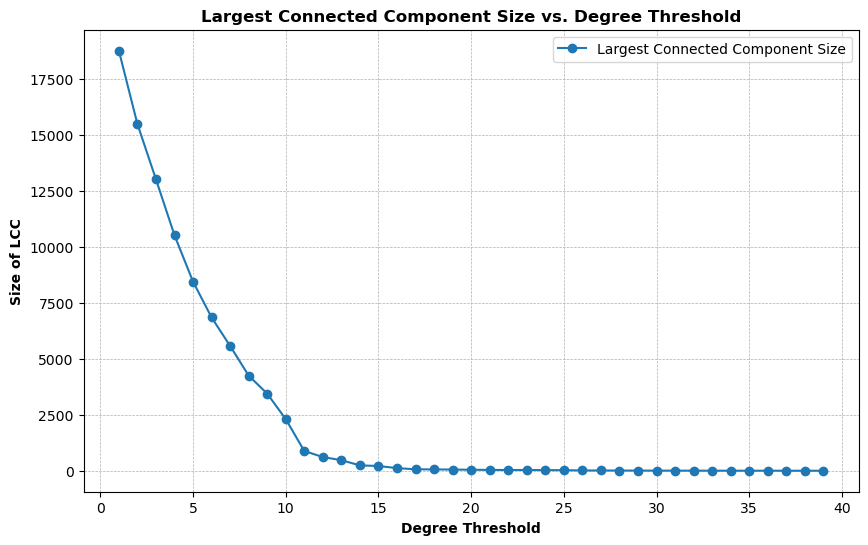

In [7]:
largest_cc_sizes = []

# Computing the size of the largest connected component for each threshold
for threshold in thresholds:
    filtered_nodes = [node for node, degree in G.degree() if degree >= threshold]
    G_filtered = G.subgraph(filtered_nodes)
    
    # Calculating the size of the largest connected component
    if len(G_filtered) > 0: 
        lcc = max(nx.connected_components(G_filtered), key=len)
        largest_cc_sizes.append(len(lcc))
    else:
        largest_cc_sizes.append(0)

# Ploting the results
plt.figure(figsize=(10, 6))
plt.plot(thresholds, largest_cc_sizes, marker='o', label="Largest Connected Component Size")
plt.title("Largest Connected Component Size vs. Degree Threshold", fontweight='bold')
plt.xlabel("Degree Threshold", fontweight='bold')
plt.ylabel("Size of LCC", fontweight='bold')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

In the two plots above, we observe a clear trade-off when choosing the degree threshold with respect to the average clustering coefficient and the size of the largest connected component. For thresholds above 14, both metrics decline at the same time, eliminating the trade-off. However, for thresholds below 14, we can see the trade-off between maintaining a higher clustering coefficient and a larger connected component. Choosing a degree threshold of 5 is justifiable, as it balances a large average clustering coefficient with a large connected component size.

# Simple Network Analytics

This part of the explainer notebook primarily includes code and insights that were not used in the paper. It presents initial statistics and relationships that helped us better understand the structure and nature of the dataset.

In [8]:
with open('business_graph_threshold.pkl', 'rb') as f:
    G = pickle.load(f)

filtered_business_ids = set(G.nodes)

filtered_reviews_df = pd.read_csv(file_path)

filtered_reviews_for_graph = filtered_reviews_df[filtered_reviews_df['business_id'].isin(filtered_business_ids)]

business_mapping = filtered_reviews_for_graph.set_index('business_id')[['name', 'city', 'address']].drop_duplicates().to_dict('index')

degree_dict = dict(G.degree())

top_5_by_degree = sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)[:5]

print("Top 5 nodes by degree with business details:")
for node, degree in top_5_by_degree:
    business_info = business_mapping.get(node, {"name": "Unknown", "city": "Unknown", "address": "Unknown"})
    print(f"Node (business_id): {node}, Name: {business_info['name']}, City: {business_info['city']}, Address: {business_info['address']}, Degree: {degree}")

Top 5 nodes by degree with business details:
Node (business_id): PrsvO1rzkgg6qFizlAoEtg, Name: Mike's Pastry, City: Boston, Address: 300 Hanover St, Degree: 44
Node (business_id): 0oGCF9xsvKe1vS6Sm3o3VQ, Name: Kokoro Tokyo Mazesoba, City: Vancouver, Address: 551 Seymour Street, Degree: 40
Node (business_id): YZs1gNSh_sN8JmN_nrpxeA, Name: Terry Black's Barbecue, City: Austin, Address: 1003 Barton Springs Rd, Degree: 36
Node (business_id): z9oCxeqOKp2QMfM24m7bUw, Name: Mary Mac's Tea Room, City: Atlanta, Address: 224 Ponce De Leon Ave NE, Degree: 34
Node (business_id): gjYyUYpTeNMp8zrw4ZDYCw, Name: Bulla Gastrobar, City: Winter Park, Address: 110 S Orlando Ave, Ste 7, Degree: 32


The top 5 nodes by degrees don't offer any particular info at first glance here. They are spread across cities and represent diverse cuisines, such as Mike's Pastry in Boston for pastries, Kokoro Tokyo Mazesoba in Vancouver for Japanese noodles, and Terry Black's Barbecue in Austin for barbecue. Alongside Mary Mac's Tea Room in Atlanta and Bulla Gastrobar in Winter Park, their centrality reflects their unique appeal or local significance, suggesting influence in this network arises from varied cultural and regional factors.

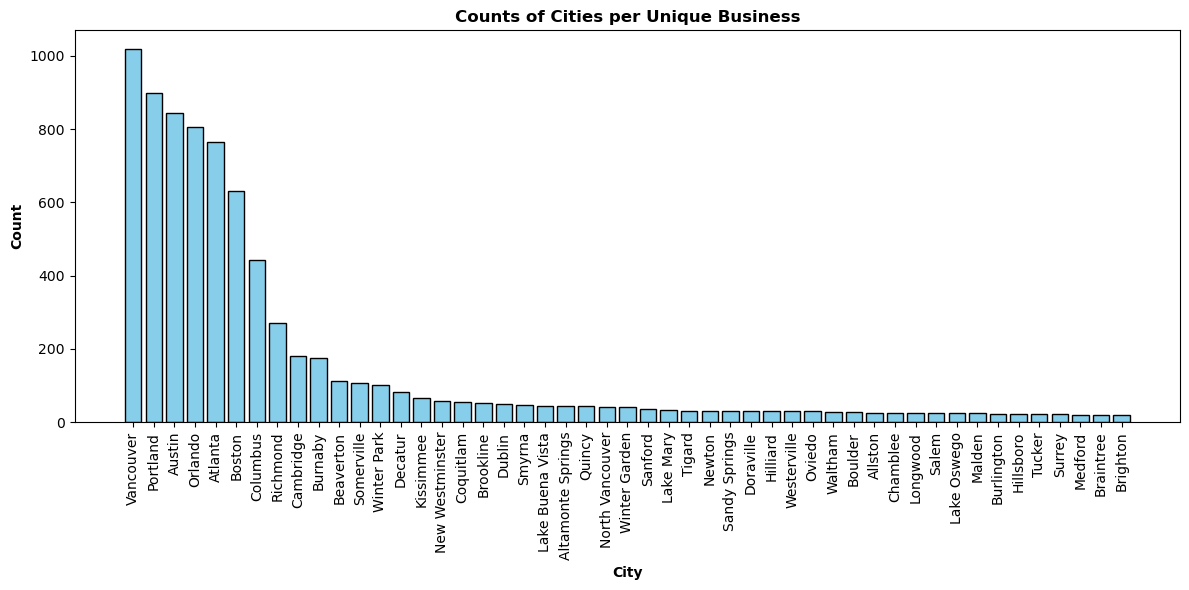

In [9]:
unique_businesses = filtered_reviews_for_graph.drop_duplicates(subset='business_id')

city_counts = unique_businesses['city'].value_counts()

filtered_city_counts = city_counts[city_counts >= 20]

plt.figure(figsize=(12, 6))
plt.bar(
    filtered_city_counts.index, 
    filtered_city_counts.values, 
    color='skyblue',
    edgecolor='black'
)
plt.title('Counts of Cities per Unique Business', fontweight='bold')
plt.xlabel('City', fontweight='bold')
plt.ylabel('Count', fontweight='bold')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

This bar chart shows the distribution of unique businesses across various cities, highlighting a clear dominance by a few major urban areas. Vancouver leads with the highest number of unique businesses, followed closely by Portland and Austin, all exceeding 900 businesses. These cities appear to be central hubs in the dataset, likely reflecting a stronger representation within the data collection process. After these leading cities, the counts gradually decrease, with cities like Orlando, Atlanta, and Boston contributing significantly but at a lower level. As we move further along the chart, there is a steep drop in the number of unique businesses, with many cities on the right-hand side having fewer than 100 businesses represented. This long-tail distribution suggests that the dataset includes a mix of major metropolitan areas and smaller cities, capturing a broad but uneven geographic spread. The stark difference between the top cities and those at the tail may reflect varying levels of economic activity, city size, or biases in data collection, making it clear that certain locations play a more prominent role in shaping the dataset.

In [10]:
average_stars = filtered_reviews_for_graph['customer_stars'].mean()

print(f"Average stars rating: {average_stars:.2f}")

Average stars rating: 3.95


In [11]:
business_stats = filtered_reviews_for_graph.groupby('business_id').agg(
    customer_stars=('customer_stars', 'mean'),
    review_count=('customer_stars', 'count')
).reset_index()

merged_data = pd.merge(
    business_stats,
    filtered_reviews_for_graph[['business_id', 'name', 'city', 'address']].drop_duplicates(),
    on='business_id'
)

filtered_data = merged_data[merged_data['review_count'] >= 10]

top_5_rated_businesses = filtered_data.sort_values(by='customer_stars', ascending=False).head(5)

top_5_rated_businesses = top_5_rated_businesses[['business_id', 'name', 'city', 'address', 'customer_stars', 'review_count']]

print("Top 5 most rated businesses (by average stars with at least 10 reviews):")
print(top_5_rated_businesses)

Top 5 most rated businesses (by average stars with at least 10 reviews):
                 business_id                         name               city  \
758   4Zx4dmZPQ6xjGAbDkhSKwQ  Norma's Plant Based Cuisine  Altamonte Springs   
5559  dZEUL3D32Ny6qQQqbFT0kQ    Sahel Market & Restaurant          Vancouver   
1965  DOmaxLcwoKfNLNGkCciOHQ      Nana's Guilty Pleasures           Portland   
2831  JsEwlEUZvxAmbffj-mpZHg              The Fried Onion           Portland   
670   41W2XwM6pnDR92Yw9v2QxQ    Mumbo Gumbo PDX -Sellwood           Portland   

                           address  customer_stars  review_count  
758             351 S State Rd 434        5.000000            60  
5559           3207 West  Broadway        5.000000            13  
1965         6108 SE Milwaukie Ave        4.980769            52  
2831                SE 3rd & Alder        4.964286            28  
670   6200 SE Milwaukie Ave, Ste C        4.954545            88  


In [12]:
business_stats = filtered_reviews_for_graph.groupby('business_id').agg(
    customer_stars=('customer_stars', 'mean'),
    review_count=('customer_stars', 'count')
).reset_index()

merged_data = pd.merge(
    business_stats,
    filtered_reviews_for_graph[['business_id', 'name', 'city', 'address']].drop_duplicates(),
    on='business_id'
)

filtered_data = merged_data[merged_data['review_count'] >= 10]

lowest_5_rated_businesses = filtered_data.sort_values(by='customer_stars', ascending=True).head(5)

lowest_5_rated_businesses = lowest_5_rated_businesses[['business_id', 'name', 'city', 'address', 'customer_stars', 'review_count']]

print("Lowest 5 rated businesses (by average stars with at least 10 reviews):")
print(lowest_5_rated_businesses)

Lowest 5 rated businesses (by average stars with at least 10 reviews):
                 business_id                       name          city  \
413   252DlOgnPandEneK1vykGA  Popeyes Louisiana Kitchen      Clermont   
6087  hZyx9RFuOdXu-wjjJmQfyA                Taco Cabana  Pflugerville   
982   6Id8x6nKtsRjFBfdxj2DdA                 McDonald's     Pataskala   
5816  fY7a3RrarPUeFHwipQa2VA                    Dunkin'      Longwood   
4914  ZwDj2eHZX8zkLoPM8HGfZg                 McDonald's       Orlando   

                   address  customer_stars  review_count  
413            16530 Sr 50        1.303030            33  
6087         15002 Fm 1825        1.333333            69  
982    103 Etna Crest Blvd        1.400000            10  
5816  801 W State Road 434        1.416667            12  
4914         1028 W Lee Rd        1.428571            28  


The results reveal some contrasts between the top-rated and lowest-rated businesses, shedding light on customer satisfaction and behavior within the dataset. The top 5 businesses by average stars, all achieving nearly perfect ratings, represent a mix of unique and niche dining experiences, that probably emphasize quality and customer satisfaction. Norma's Plant Based Cuisine in Altamonte Springs stands out with a perfect 5.0 rating across 60 reviews, highlighting its appeal to customers seeking plant-based options. Similarly, Sahel Market & Restaurant in Vancouver, with 13 reviews, and Nana's Guilty Pleasures in Portland, with 52 reviews, cater to more localized or specialized audiences. The high ratings, coupled with their moderate review counts, suggest these businesses excel in providing consistent, high-quality experiences, likely resonating with a loyal customer base. Portland’s notable presence in this list, with three businesses, hints at the city’s vibrant and diverse food culture contributing to customer satisfaction.

In contrast, the lowest-rated businesses are dominated by large chains or high-traffic establishments like Popeyes, McDonald's, Dunkin’, and Taco Cabana. Their average ratings, ranging from 1.30 to 1.42, reflect significant dissatisfaction among customers. Unlike the top-rated businesses, these establishments have higher review counts, such as Taco Cabana’s 69 reviews and Popeyes’ 33 reviews. This suggests that these businesses attract a larger and more diverse customer base, which may lead to greater scrutiny and more polarized reviews. Common issues such as inconsistent service, long wait times, or unmet expectations often plague chain restaurants and may contribute to their low ratings. The presence of multiple McDonald’s locations on this list underscores how global chains face challenges in maintaining uniform quality across different sites.

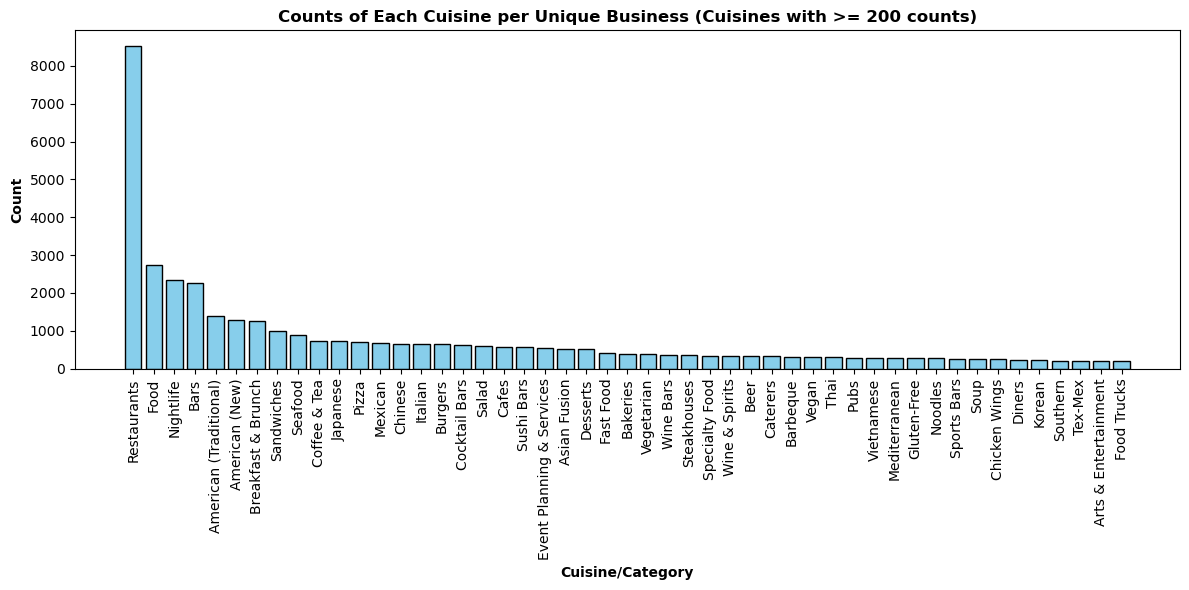

In [13]:
unique_businesses = filtered_reviews_for_graph.drop_duplicates(subset='business_id')
all_categories = unique_businesses['categories'].str.split(',').explode()
all_categories = all_categories.str.strip()
cuisine_counts = all_categories.value_counts()
filtered_cuisine_counts = cuisine_counts[cuisine_counts >= 200]

plt.figure(figsize=(12, 6))
plt.bar(
    filtered_cuisine_counts.index, 
    filtered_cuisine_counts.values, 
    color='skyblue',
    edgecolor='black'
)
plt.title('Counts of Each Cuisine per Unique Business (Cuisines with >= 200 counts)', fontweight='bold')
plt.xlabel('Cuisine/Category', fontweight='bold')
plt.ylabel('Count', fontweight='bold')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

This bar chart highlights the distribution of cuisines or categories across unique businesses with at least 200 counts, and it reveals some clear outliers in the data. The most significant observation is the massive spike for categories labeled as "Restaurants" and "Food." These are exceptionally broad and generic labels, likely encompassing a wide variety of actual cuisines, which explains their disproportionately high counts compared to other categories. Such broad terms are not specific cuisines, and their inclusion skews the distribution heavily.

Similarly, we notice other non-cuisine categories like "Nightlife," which raises questions about its relevance in a dataset that is seemingly focused on dining or food establishments. "Nightlife" might refer to bars, lounges, or clubs, but it certainly doesn’t belong alongside specific cuisines like "Japanese," "Mexican," or "Italian." This lack of specificity in some categories dilutes the meaningfulness of the dataset and creates inconsistencies in the analysis.

Beyond these outliers, the chart also provides insights into actual cuisine preferences, with more specific categories such as "American (Traditional)," "American (New)," "Breakfast & Brunch," and "Pizza" showing substantial representation. The dataset is also of restaurants in America and Canada, so this also explains the high counts of american cuisines. This suggests these cuisines are popular across the dataset, reflecting widespread appeal. 

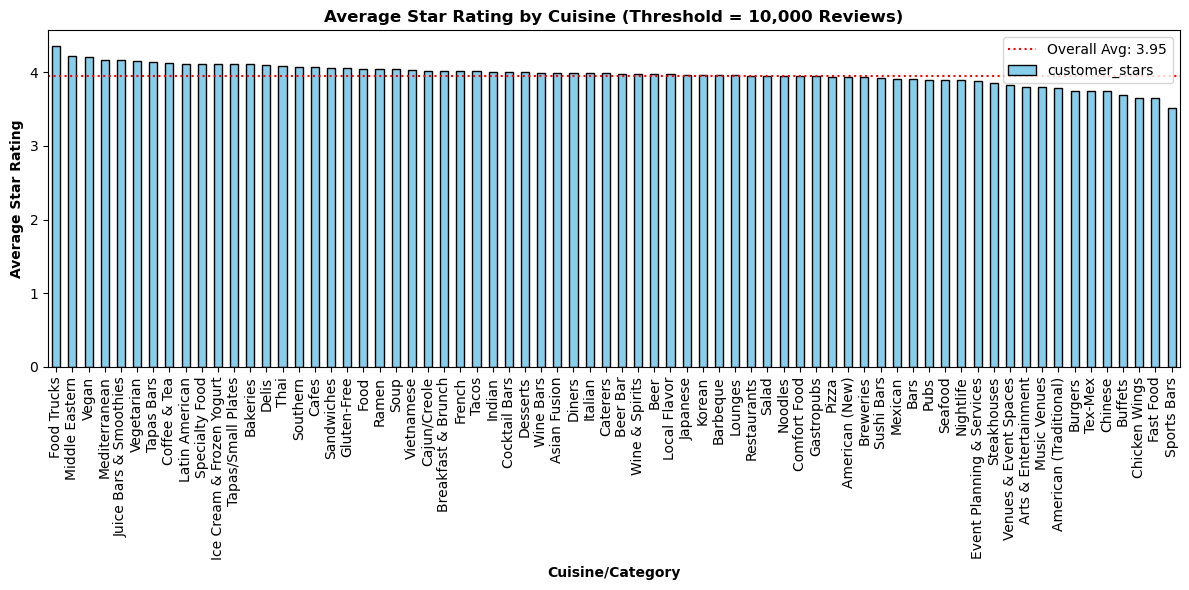

In [14]:
filtered_df = filtered_reviews_for_graph.dropna(subset=['categories', 'customer_stars'])

filtered_df['categories_split'] = filtered_df['categories'].str.split(',')
exploded_df = filtered_df.explode('categories_split')

exploded_df['categories_split'] = exploded_df['categories_split'].str.strip()

average_stars_per_cuisine = exploded_df.groupby('categories_split')['customer_stars'].mean()

review_counts_per_cuisine = exploded_df['categories_split'].value_counts()

filtered_average_stars = average_stars_per_cuisine[review_counts_per_cuisine >= 10000]

plt.figure(figsize=(12, 6))
filtered_average_stars.sort_values(ascending=False).plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Average Star Rating by Cuisine (Threshold = 10,000 Reviews)', fontweight='bold')
plt.xlabel('Cuisine/Category', fontweight='bold')
plt.ylabel('Average Star Rating', fontweight='bold')

overall_average_rating = 3.95
plt.axhline(y=overall_average_rating, color='red', linestyle='dotted', linewidth=1.5, label=f'Overall Avg: {overall_average_rating}')

plt.legend()

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

This bar chart shows the average star rating for each cuisine category, filtered to include categories with at least 10,000 reviews. A red dotted line is drawn across the plot to represent the overall average star rating of 3.95. The plot provides a clear way to compare how different cuisines or categories perform relative to the overall average.

Most of the categories cluster closely around the overall average of 3.95, suggesting that customer satisfaction is relatively consistent across popular categories. However, there is some variation, with a few categories slightly exceeding or falling below this benchmark. Specific cuisines like "Food Trucks," "Middle Eastern," and "Vegan" appear to perform well above the average, indicating strong customer satisfaction in these categories. In contrast, categories like "Sports Bars," "Fast Food," and "Chicken Wings" fall below the average, which may reflect customer dissatisfaction or challenges with maintaining quality in these types of establishments.

The chart also highlights an interesting observation about the dataset itself: many of the listed categories are not strictly cuisines. Categories like "Nightlife," "Event Planning & Services," and "Venues & Event Spaces" are more about activities or services than food, which introduces noise into the analysis. These broad or ambiguous labels dilute the focus on actual cuisines and might require further refinement or filtering for more meaningful insights. Overall, the chart suggests that while many cuisines are rated similarly, certain categories stand out for either exceptional or subpar customer satisfaction, and some entries in the dataset could benefit from better categorization.

In [15]:
review_counts_per_cuisine = exploded_df['categories_split'].value_counts()

average_stars_per_cuisine = exploded_df.groupby('categories_split')['customer_stars'].mean()

unique_business_ids_per_cuisine = exploded_df.groupby('categories_split')['business_id'].nunique()

cuisine_stats = pd.DataFrame({
    'average_stars': average_stars_per_cuisine,
    'review_count': review_counts_per_cuisine,
    'unique_business_ids': unique_business_ids_per_cuisine
})

cuisine_stats_filtered = cuisine_stats[cuisine_stats['unique_business_ids'] >= 10]

top_5_cuisines = cuisine_stats_filtered.sort_values(by='average_stars', ascending=False).head(5)

bottom_5_cuisines = cuisine_stats_filtered.sort_values(by='average_stars', ascending=True).head(5)

print("Top 5 Highest Star Rating Cuisines (with review counts and unique business IDs):")
print(top_5_cuisines)

print("\nBottom 5 Lowest Star Rating Cuisines (with review counts and unique business IDs):")
print(bottom_5_cuisines)

Top 5 Highest Star Rating Cuisines (with review counts and unique business IDs):
                  average_stars  review_count  unique_business_ids
categories_split                                                  
Ethiopian              4.494170          1801                   15
Flowers & Gifts        4.493145          2480                   15
Farmers Market         4.371622          1184                   14
Food Trucks            4.350544         16269                  200
Venezuelan             4.348837          1849                   12

Bottom 5 Lowest Star Rating Cuisines (with review counts and unique business IDs):
                  average_stars  review_count  unique_business_ids
categories_split                                                  
Pool Halls             2.940171           702                   10
Arcades                3.096357          2086                   25
Dance Clubs            3.302010          1841                   23
Eatertainment          3.330640

These results highlight some contrasts between the highest and lowest-rated cuisines or categories, providing insights into customer satisfaction and engagement within the dataset. The top-rated categories, such as Ethiopian and Venezuelan, achieve exceptionally high average star ratings (above 4.3) while having relatively modest review counts and a small number of unique businesses. This suggests that these cuisines are niche or less widespread, but the businesses that do exist within these categories are highly appreciated for their quality or uniqueness. For example, Food Trucks, with a much higher review count (16,269) and a larger number of unique businesses (200), still maintains a strong average rating, indicating both popularity and consistent customer satisfaction across a broader scale. The inclusion of non-cuisine categories like Flowers & Gifts and Farmers Market in the top ratings reflects some overlap in the dataset between food-related and non-food-related businesses, which may need refinement for more targeted analysis.

On the other hand, the lowest-rated categories, such as Pool Halls, Arcades, and Dance Clubs, reflect less favorable customer experiences, with average ratings below 3.5. These categories, like Eatertainment and Bowling, are not strictly cuisines but represent entertainment-focused services. The lower ratings may stem from the challenges of managing customer expectations in recreational settings, where factors like atmosphere, wait times, or service quality can significantly impact satisfaction. Additionally, these categories generally have higher review counts and larger numbers of unique businesses compared to the top-rated categories, suggesting that they cater to broader audiences but face more scrutiny and diverse opinions.

Overall, this reveals a divide between niche, highly appreciated categories (like Ethiopian and Venezuelan) and broad, service-oriented categories (like Pool Halls and Arcades) that struggle with maintaining consistent satisfaction. This also highlights the complexity of analyzing mixed datasets containing both food-related and entertainment-focused categories.

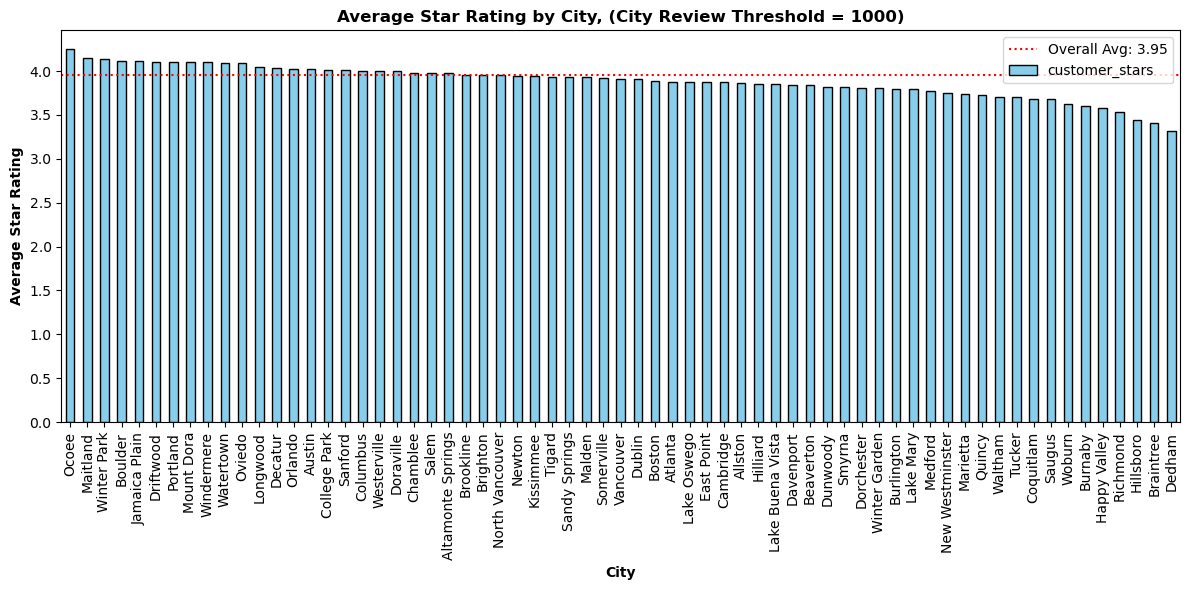

In [16]:
filtered_df = filtered_reviews_for_graph.dropna(subset=['city', 'customer_stars'])

average_stars_per_city = filtered_df.groupby('city')['customer_stars'].mean()

city_review_counts = filtered_df['city'].value_counts()

filtered_average_stars = average_stars_per_city[city_review_counts >= 1000]

plt.figure(figsize=(12, 6))
filtered_average_stars.sort_values(ascending=False).plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Average Star Rating by City, (City Review Threshold = 1000)', fontweight='bold')
plt.xlabel('City', fontweight='bold')
plt.ylabel('Average Star Rating', fontweight='bold')

overall_average_rating = 3.95
plt.axhline(y=overall_average_rating, color='red', linestyle='dotted', linewidth=1.5, label=f'Overall Avg: {overall_average_rating}')

plt.legend()

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

This chart shows the average star rating for cities with at least 1,000 reviews, accompanied by a red dotted line representing the overall average star rating of 3.95. At first glance, the data doesn’t present a significant variation in ratings across the cities, as most cities cluster very close to the overall average. This uniformity suggests that customer satisfaction, as measured by star ratings, remains consistent regardless of location for cities meeting the review threshold.

The absence of standout cities either significantly above or below the average makes it difficult to draw meaningful conclusions about how specific cities influence ratings. The overall similarity could be reflective of homogenized experiences across businesses in these cities, potentially driven by standardization in services, expectations, or the way ratings are given.

While this uniformity might not provide deep insights, it does confirm that no city appears to have an overwhelmingly positive or negative bias in customer satisfaction relative to others. Further analysis could focus on digging deeper into specific business types or cuisines within these cities to see if variations exist at a more granular level. Without such additional breakdowns, this chart alone doesn’t provide much actionable information or notable trends.

In [17]:
filtered_df = filtered_reviews_for_graph.dropna(subset=['city', 'customer_stars'])

average_stars_per_city = filtered_df.groupby('city')['customer_stars'].mean()

review_counts_per_city = filtered_df['city'].value_counts()

unique_business_ids_per_city = filtered_df.groupby('city')['business_id'].nunique()

city_stats = pd.DataFrame({
    'average_stars': average_stars_per_city,
    'review_count': review_counts_per_city,
    'unique_business_ids': unique_business_ids_per_city
})

top_5_cities = city_stats.sort_values(by='average_stars', ascending=False).head(5)
bottom_5_cities = city_stats.sort_values(by='average_stars', ascending=True).head(5)

print("Top 5 Cities by Average Stars (with Review Counts and Unique Business IDs):")
print(top_5_cities)

print("\nBottom 5 Cities by Average Stars (with Review Counts and Unique Business IDs):")
print(bottom_5_cities)

print("\nUnique Business IDs and Names in Top 5 Cities:")
for city in top_5_cities.index:
    city_businesses = filtered_df[filtered_df['city'] == city][['business_id', 'name']].drop_duplicates()
    print(f"\n{city}:")
    print(city_businesses.to_string(index=False))

print("\nUnique Business IDs and Names in Bottom 5 Cities:")
for city in bottom_5_cities.index:
    city_businesses = filtered_df[filtered_df['city'] == city][['business_id', 'name']].drop_duplicates()
    print(f"\n{city}:")
    print(city_businesses.to_string(index=False))

Top 5 Cities by Average Stars (with Review Counts and Unique Business IDs):
                 average_stars  review_count  unique_business_ids
city                                                             
Union Park            4.806452            31                    1
Carroll               4.692308            13                    1
Bay Lake              4.666667             9                    1
Brice                 4.642857            28                    1
College Park Ga       4.619048            42                    1

Bottom 5 Cities by Average Stars (with Review Counts and Unique Business IDs):
                average_stars  review_count  unique_business_ids
city                                                            
PORTLAND             2.096154            52                    1
ORLANDO              2.591549            71                    2
Everett              2.627986           293                    5
Stone Mountain       2.634921            63              

In [18]:
filtered_df = filtered_reviews_for_graph.dropna(subset=['city', 'customer_stars'])

average_stars_per_city = filtered_df.groupby('city')['customer_stars'].mean()

review_counts_per_city = filtered_df['city'].value_counts()

unique_business_ids_per_city = filtered_df.groupby('city')['business_id'].nunique()

city_stats = pd.DataFrame({
    'average_stars': average_stars_per_city,
    'review_count': review_counts_per_city,
    'unique_business_ids': unique_business_ids_per_city
})

city_stats_filtered = city_stats[city_stats['unique_business_ids'] >= 10]

top_5_cities = city_stats_filtered.sort_values(by='average_stars', ascending=False).head(5)
bottom_5_cities = city_stats_filtered.sort_values(by='average_stars', ascending=True).head(5)

print("Top 5 Cities by Average Stars (with Review Counts and Unique Business IDs):")
print(top_5_cities)

print("\nBottom 5 Cities by Average Stars (with Review Counts and Unique Business IDs):")
print(bottom_5_cities)

print("\nUnique Business IDs and Names in Top 5 Cities:")
for city in top_5_cities.index:
    city_businesses = filtered_df[filtered_df['city'] == city][['business_id', 'name']].drop_duplicates()
    print(f"\n{city}:")
    print(city_businesses.to_string(index=False))

print("\nUnique Business IDs and Names in Bottom 5 Cities:")
for city in bottom_5_cities.index:
    city_businesses = filtered_df[filtered_df['city'] == city][['business_id', 'name']].drop_duplicates()
    print(f"\n{city}:")
    print(city_businesses.to_string(index=False))

Top 5 Cities by Average Stars (with Review Counts and Unique Business IDs):
                average_stars  review_count  unique_business_ids
city                                                            
Winter Springs       4.295014           722                   10
Ocoee                4.251984          1008                   14
Worthington          4.222061           689                   12
Maitland             4.144928          1104                   15
Winter Park          4.135987         11707                  102

Bottom 5 Cities by Average Stars (with Review Counts and Unique Business IDs):
           average_stars  review_count  unique_business_ids
city                                                       
Dedham          3.315126          1190                   16
Bee Cave        3.375212           589                   10
Braintree       3.407666          1722                   20
Clackamas       3.425557           853                   13
Hillsboro       3.444103     

The data shows a pretty clear difference between the top 5 and bottom 5 cities by average star ratings. In the top-rated group, Winter Springs takes the lead with an impressive average of 4.30, although it’s based on only 722 reviews and 10 businesses, which isn’t a lot. Ocoee, Worthington, and Maitland all follow with ratings above 4.1, and they also have smaller numbers of reviews and businesses. What’s interesting is Winter Park—it’s slightly lower at 4.14 but has a huge number of reviews (11,707!) and 102 businesses. That makes it stand out as a city where not only do people seem happy with their experiences, but there’s also a much bigger and more active business scene.

On the flip side, the bottom-rated cities all hover between 3.31 and 3.44, which is noticeably below the overall average of 3.95. Dedham and Bee Cave have fewer reviews and businesses, so their lower ratings might be tied to just a handful of places dragging the averages down. Meanwhile, cities like Braintree and Hillsboro have more reviews and businesses, which suggests a more widespread issue with customer satisfaction. Clackamas falls somewhere in between—it’s not as small as Dedham but also doesn’t have the larger numbers of Braintree or Hillsboro.

All in all, smaller cities like Winter Springs or Dedham seem to have more extreme ratings, either really high or really low, probably because a few businesses can have a big impact. Bigger cities like Winter Park or Hillsboro show how larger numbers of businesses and reviews can either maintain consistent quality (like Winter Park) or highlight more widespread dissatisfaction (like Hillsboro). It’s a good reminder that size and diversity can play a big role in shaping these kinds of averages.

In [19]:
degree_assortativity = nx.degree_assortativity_coefficient(G)

print(f"Degree Assortativity Coefficient: {degree_assortativity:.4f}")

Degree Assortativity Coefficient: 0.2010


In our network a link between two restaurants exists when a user has reviewed both. This means that the degree assortativity coefficient of 0.2010 takes on a specific interpretation. A positive assortativity in this context means that restaurants with similar levels of user overlap are slightly more likely to be connected.

For example, popular restaurants with high degrees (those reviewed by many users who also review other restaurants) are more likely to be connected to other similarly popular restaurants. This could reflect shared customer bases for well-known or high-profile dining spots that attract active reviewers. For instance, users who frequently review upscale or trendy restaurants might visit and review multiple such restaurants, creating a cluster of highly connected nodes.

Similarly, less-connected restaurants, those with fewer overlapping reviewers—are more likely to be linked to other low-degree restaurants. These might represent smaller, more niche establishments with localized or specific audiences that don't frequently venture into larger networks of dining options.

This moderate positive assortativity suggests some level of clustering based on shared customer behavior: Maybe popular restaurants tend to be indirectly connected through active reviewers, while niche restaurants are more isolated and connected within their own smaller communities. However, the value of 0.2010 indicates that this effect is not particularly strong, meaning there is still significant mixing between restaurants of different degrees. For example, a highly connected restaurant may occasionally share a reviewer with a smaller, niche spot, bridging the gap between the two clusters. This balance reflects the diversity in user behavior, where some users stick to specific types of restaurants, while others explore a wide range of dining options.

# Network Analysis (Communities & Clustering)

In this section we will look into how restaurants are grouped and what people are saying about them. We will use **Louvain communities** to find natural clusters of restaurants based on shared reviewers, while also looking at **attribute-based communities**, such as city and cuisine for comparison. For the Louvain communities, we will implement **TF-IDF** to see if there are unique terms in the different communities.

In [20]:
# Removing generic categories like 'Food' and 'Restaurants'
def normalize_categories(categories):
    excluded_categories = {'Food', 'Restaurants', 'Bars', 'Nightlife'}
    if isinstance(categories, str):
        return [
            cat.strip() 
            for cat in categories.split(",") 
            if cat.strip() not in excluded_categories
        ]
    return ["No Category"]  # Default for missing categories

filtered_reviews_for_graph['categories'] = filtered_reviews_for_graph['categories'].apply(normalize_categories)

# Creating a mapping from business_id to categories and city
categories_mapping = filtered_reviews_for_graph.set_index('business_id')['categories'].to_dict()
city_mapping = filtered_reviews_for_graph.set_index('business_id')['city'].to_dict()

# Adding 'categories' as a node attribute
nx.set_node_attributes(G, categories_mapping, 'categories')

# Adding 'city' as a node attribute
nx.set_node_attributes(G, city_mapping, 'city')

# Saving the updated graph for future use
with open('business_graph_with_attributes.pkl', 'wb') as f:
    pickle.dump(G, f)

/var/folders/8l/1xzphzy96ynfmykt3ln6dhdc0000gn/T/ipykernel_93959/833621120.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_reviews_for_graph['categories'] = filtered_reviews_for_graph['categories'].apply(normalize_categories)


We only want each node in the network to have one category attribute. Now they each have a list of attributes which will create inconsistencies when creating the communities. To avoid this we assign each node one of their categories, which is decided based on how many times the category is mentioned for all business id's. The reason for not counting all categories for all data points is that the amount of reviews for each business id would have a huge impact on the weight. Furthermore, this also insures the removal of very unique cuisines and other noise for this part of the data.  

In [21]:
# Function for calculating the weights of categories
def calculate_category_weights(graph):
    node_categories = defaultdict(set)

    for node in graph.nodes:
        raw_categories = graph.nodes[node].get('categories', [])
        
        if isinstance(raw_categories, list):
            categories = raw_categories
        elif isinstance(raw_categories, str):
            categories = raw_categories.split(", ")
        else:
            categories = []
        
        node_categories[node].update(categories)

    category_weights = Counter()
    for categories in node_categories.values():
        for category in categories:
            category_weights[category] += 1

    return dict(category_weights)

We can now use the function to create category-based communities, along with Louvain communities and city communities. For each of the three community types we calculate the modularity. We do this to evaluate the quality of the communities structures within our graph.

In [22]:
# Setting seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)


# Function to calculate the modularity
def calculate_modularity(graph, communities):
    L = graph.number_of_edges()
    modularity = 0
    for community in communities:
        subgraph = graph.subgraph(community)
        L_c = subgraph.number_of_edges()
        k_c = sum(dict(graph.degree(community)).values())
        modularity += (L_c / L) - (k_c / (2 * L)) ** 2
    return modularity



# Louvain communities
louvain_partition = community_louvain.best_partition(G)
louvain_communities = defaultdict(list)
for node, community_id in louvain_partition.items():
    louvain_communities[community_id].append(node)

louvain_community_list = list(louvain_communities.values())

# Calculating modularity for Louvain communities
louvain_modularity_manual = calculate_modularity(G, louvain_community_list)
print(f"Louvain Modularity (Manual): {louvain_modularity_manual:.4f}")



# City-based communities
city_communities = defaultdict(list)
for node in G.nodes:
    city = G.nodes[node].get('city', 'No Category')
    city_communities[city].append(node)

# Calculating modularity for City Communities
city_community_list = list(city_communities.values())
city_modularity_manual = calculate_modularity(G, city_community_list)
print(f"City-based Modularity (Manual): {city_modularity_manual:.4f}")



# Category-based communities
category_weights = calculate_category_weights(G)

# Assigning the highest-weighted category to each node
highest_weighted_category = {}
for node in G.nodes:
    categories = G.nodes[node].get('categories', ["No Category"])
    if categories:
        highest_weighted_category[node] = max(categories, key=lambda c: category_weights.get(c, 0))
    else:
        highest_weighted_category[node] = "No Category"

weighted_category_communities = defaultdict(list)
for node, category in highest_weighted_category.items():
    weighted_category_communities[category].append(node)

weighted_category_community_list = list(weighted_category_communities.values())

# Calculating modularity for category communities
weighted_category_modularity_manual = calculate_modularity(G, weighted_category_community_list)
print(f"Category-based Modularity (Manual): {weighted_category_modularity_manual:.4f}")

Louvain Modularity (Manual): 0.9481
City-based Modularity (Manual): 0.4988
Category-based Modularity (Manual): 0.1858


These results show that the Louvain communities have the highest modularity, 0.9481, meaning that they are well-defined and strongly connected by shared reviewers. On the other hand, the city-based communities with a modularity of 0.4988 and the category-based communities with a modularity of 0.1858 are significantly lower, which shows that city and cuisine type are less reflective of the natural structure of the network. This shows that the natural groupings found by the Louvain Algorithm do a much better job of capturing how restaurants are connected through shared reviewers in the network.

We will now look at the overlap between the structure-based Louvain communities and the attribute-based groupings, categories, and cities in the restaurant-review network. Using confusion matrices, we can establish how well the Louvain communities fit into the attribute-based groupings, for example, cuisine type or city. This helps us investigate whether the communities detected by Louvain reflect any of the known real-world features or are entirely new patterns.


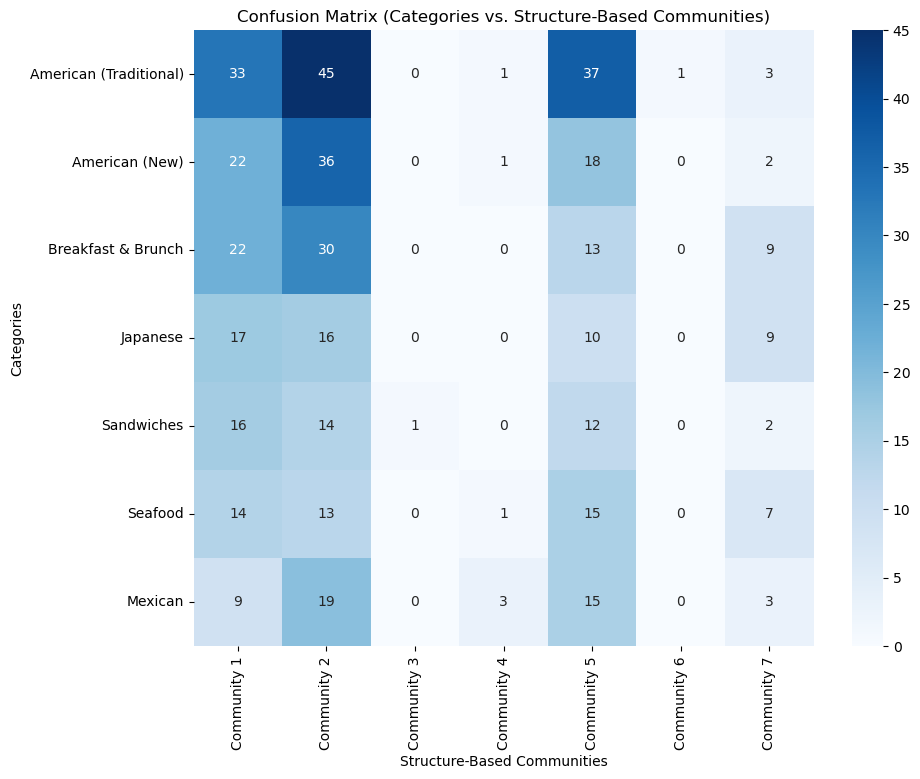

In [23]:
for node in G.nodes:
    all_categories = G.nodes[node].get('categories', ["No Category"])
    if isinstance(all_categories, str):
        all_categories = [cat.strip() for cat in all_categories.split(",")]
    
    if all_categories:
        highest_category = max(all_categories, key=lambda cat: category_weights.get(cat, 0))
    else:
        highest_category = "No Category"
    
    G.nodes[node]['categories'] = highest_category

all_categories_list = list(nx.get_node_attributes(G, 'categories').values())
category_frequency = Counter(all_categories_list)

# Getting only the top 7 categories by frequency
top_categories = [category for category, _ in category_frequency.most_common(7)]


# Identifying the top 7 structure-based communities by size
top_communities = sorted(louvain_community_list, key=len, reverse=True)[:7]

community_labels = {node: community_id for community_id, nodes in enumerate(louvain_community_list) for node in nodes}

# Initializing the matrix D (7x7) for top categories and communities
D = [[0 for _ in range(len(top_communities))] for _ in range(len(top_categories))]

category_index = {category: idx for idx, category in enumerate(top_categories)}
community_index = {community_id: idx for idx, community_id in enumerate(range(len(top_communities)))}

for node in G.nodes:
    category = G.nodes[node]['categories']
    node_community = community_labels[node] 
    
    if node_community in community_index:
        community_idx = community_index[node_community]
        
        if category in category_index:
            category_idx = category_index[category]
            D[category_idx][community_idx] += 1

# Visualizing the matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    D, annot=True, fmt="d", cmap="Blues",
    xticklabels=[f"Community {i+1}" for i in range(7)],
    yticklabels=top_categories
)
plt.xlabel("Structure-Based Communities")
plt.ylabel("Categories")
plt.title("Confusion Matrix (Categories vs. Structure-Based Communities)")
plt.show()

In the category-based matrix, we see that certain categories, like "American (Traditional)" are spread across multiple Louvain communities, indicating shared reviewers across different clusters. Other categories, such as "Japanese" and "Sandwiches," also show overlap, suggesting that reviewers often review restaurants of different types. That indicates that Louvain communities capture broader connections which go beyond simple single-category groupings.

Now we do the exact same for the cities. 

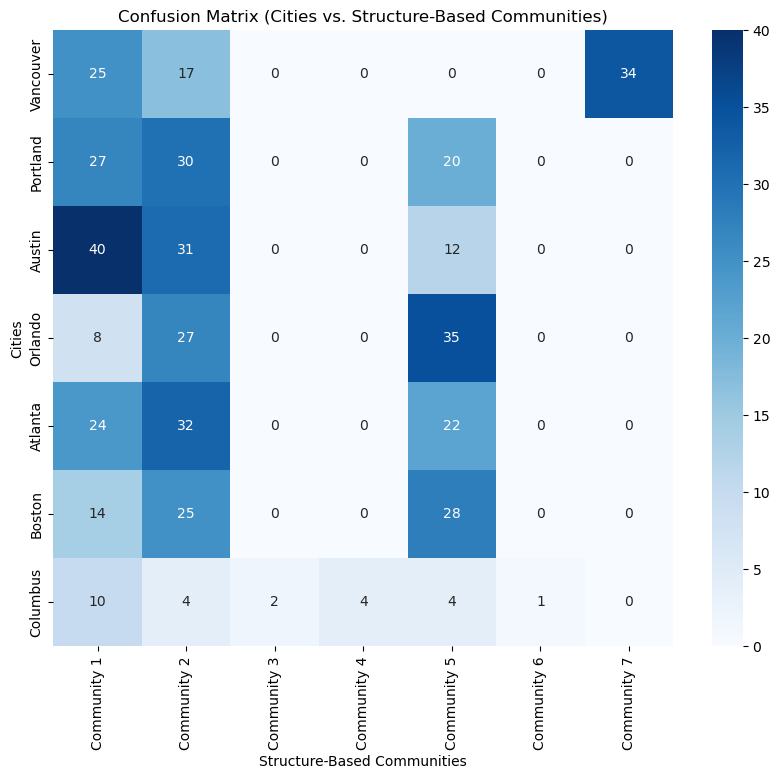

In [24]:
for node in G.nodes:
    city = G.nodes[node].get('city', "No City") 
    G.nodes[node]['city'] = city

# Identifying the top 7 cities by frequency across all businesses
all_cities_list = list(nx.get_node_attributes(G, 'city').values())
top_cities = [city for city, _ in Counter(all_cities_list).most_common(7)]


# Initializing the matrix D_City (7x7) for top cities and communities
D_City = [[0 for _ in range(len(top_communities))] for _ in range(len(top_cities))]

city_index = {city: idx for idx, city in enumerate(top_cities)}

for node in G.nodes:
    city = G.nodes[node]['city']  
    node_community = community_labels[node]  

    if node_community in community_index and city in city_index:
        city_idx = city_index[city]
        community_idx = community_index[node_community]
        D_City[city_idx][community_idx] += 1

# Visualizing the matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    D_City, annot=True, fmt="d", cmap="Blues",
    xticklabels=[f"Community {i+1}" for i in range(7)],
    yticklabels=top_cities
)
plt.xlabel("Structure-Based Communities")
plt.ylabel("Cities")
plt.title("Confusion Matrix (Cities vs. Structure-Based Communities)")
plt.show()

In the city-based matrix, some cities are more closely aligned with specific Louvain communities, reflecting more localized behavior from reviewers. Cities like Orlando, however, show overlap across multiple communities, indicating shared reviewers between distinct cities. This suggests that Louvain communities represent patterns in the data that do not strictly align with the cities but rather captures broader trends in user behavior.

We now want to implement **TF-IDF** to see if there are any terms in the user reviews that are unique for the structure-based communities. 

In [25]:
restaurant_reviews = filtered_reviews_for_graph.groupby('business_id')['text_'].apply(' '.join).to_dict()

# Initializing the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=500, stop_words='english') 
tfidf_matrix = tfidf_vectorizer.fit_transform(restaurant_reviews.values())

In [26]:
# Grouping the reviews by Louvain Communities
community_reviews = defaultdict(str)

for node, community_id in louvain_partition.items():
    if node in filtered_reviews_for_graph['business_id'].values:
        reviews = filtered_reviews_for_graph.loc[filtered_reviews_for_graph['business_id'] == node, 'text_'].dropna().tolist()
        community_reviews[community_id] += " ".join(reviews)

In [27]:
# Grouping the reviews by business_id
grouped_reviews = filtered_reviews_for_graph.groupby('business_id')['text_'].apply(lambda x: " ".join(x)).to_dict()

# Aggregating the reviews by community
community_reviews = defaultdict(str)

for node, community_id in louvain_partition.items():
    if node in grouped_reviews: 
        community_reviews[community_id] += grouped_reviews[node]

# Identifying the Top 7 Communities with non-empty reviews
top_communities = sorted(community_reviews.items(), key=lambda x: len(x[1]), reverse=True)[:7]

# Creating Word Clouds for each top community
for idx, (community_id, reviews) in enumerate(top_communities):
    if not reviews.strip():
        print(f"Community {community_id} has no reviews. Skipping.")
        continue

    wordcloud = WordCloud(
        width=800, height=400, background_color='white',
        max_words=100
    ).generate(reviews)

    # Plotting the word cloud
    #plt.figure(figsize=(10, 5))
    #plt.imshow(wordcloud, interpolation="bilinear")
    #plt.axis("off")
    #plt.title(f"Word Cloud for Community {community_id} (Top {idx + 1})", fontsize=16)
    #plt.show()

From the 7 Word Clouds we first see common themes across the communities. All Word Clouds are dominated by words like "food," "place," "service," "great," and "good". These words don't help us identify unique patterns based on their communities, so we remove them for a second iteration to see if the Word Clouds become more distinctive from one another.

In [28]:
# Custom stopwords
custom_stopwords = set(STOPWORDS).union({"food", "place", "service", "great", "good"})

grouped_reviews = filtered_reviews_for_graph.groupby('business_id')['text_'].apply(lambda x: " ".join(x)).to_dict()
community_reviews = defaultdict(str)

for node, community_id in louvain_partition.items():
    if node in grouped_reviews: 
        community_reviews[community_id] += grouped_reviews[node]

top_communities = sorted(community_reviews.items(), key=lambda x: len(x[1]), reverse=True)[:7]

for idx, (community_id, reviews) in enumerate(top_communities):
    if not reviews.strip():
        print(f"Community {community_id} has no reviews. Skipping.")
        continue

    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        max_words=100,
        stopwords=custom_stopwords 
    ).generate(reviews)

    # Plotting the word clouds
    #plt.figure(figsize=(10, 5))
    #plt.imshow(wordcloud, interpolation="bilinear")
    #plt.axis("off")
    #plt.title(f"Word Cloud for Community {community_id} (Top {idx + 1})", fontsize=16)
    #plt.show()

For the seccond iteration we see that the Word Clouds for the top 7 communities show common themes across all communities, such as "delicious", "ordered", "drink" and "amazing", which show us that there are shared priorities like food quality, drink options, and positive dining experiences. While there are strong overlaps we also see some distinctions. For example, some communities emphasize service-related terms like "wait" and "server", suggesting a focus on customer service, while others highlight menu and meal-specific terms like "pizza" or "burger". These differences may point to specific dining preferences or experiences that are unique to certain communities. Overall, the Word Clouds still hold enough general terms to identify shared values while showing slight variations that provide insights into each community.

In [29]:
with open('business_graph_threshold.pkl', 'rb') as f:
    G = pickle.load(f)

nx.set_node_attributes(G, categories_mapping, 'categories')

nx.set_node_attributes(G, city_mapping, 'city')

louvain_partition = community_louvain.best_partition(G)

nx.set_node_attributes(G, louvain_partition, 'louvain_community')

for node in G.nodes:
    all_categories = G.nodes[node].get('categories', ["No Category"])
    if isinstance(all_categories, str):
        all_categories = [cat.strip() for cat in all_categories.split(",")]

    if all_categories:
        highest_category = max(all_categories, key=lambda cat: category_weights.get(cat, 0))
    else:
        highest_category = "No Category"
    
    G.nodes[node]['categories'] = highest_category  

for node in G.nodes:
    node_data = G.nodes[node]
    filtered_attributes = {
        'city': node_data.get('city', 'Unknown City'),
        'categories': node_data.get('categories', 'No Category'),
        'louvain_community': node_data.get('louvain_community', 'Unknown') 
    }
    G.nodes[node].clear()
    G.nodes[node].update(filtered_attributes)

with open('business_graph_with_filtered_attributes.pkl', 'wb') as f:
    pickle.dump(G, f)

100%|█████████████████████████████████████████████████████████████████████████| 2000/2000 [04:00<00:00,  8.31it/s]


BarnesHut Approximation  took  135.31  seconds
Repulsion forces  took  94.94  seconds
Gravitational forces  took  1.07  seconds
Attraction forces  took  0.97  seconds
AdjustSpeedAndApplyForces step  took  3.56  seconds


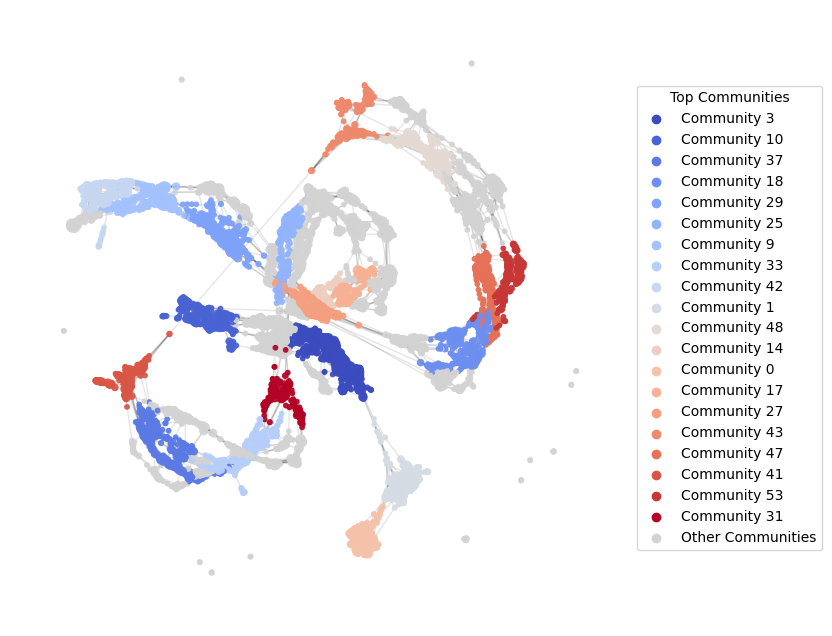

In [30]:
G.remove_edges_from(nx.selfloop_edges(G))
G.remove_nodes_from(list(nx.isolates(G)))

partition = community_louvain.best_partition(G, random_state=42)

forceatlas2 = ForceAtlas2(
    outboundAttractionDistribution=True,
    linLogMode=False,
    adjustSizes=False,
    edgeWeightInfluence=1.0,
    jitterTolerance=1.0,
    barnesHutOptimize=True,
    barnesHutTheta=1.2,
    scalingRatio=2.0,
    strongGravityMode=False,
    gravity=20.0,
    verbose=True
)
positions = forceatlas2.forceatlas2_networkx_layout(G, iterations=2000)

community_sizes = {}
for node, community in partition.items():
    if community not in community_sizes:
        community_sizes[community] = 0
    community_sizes[community] += 1

sorted_communities = sorted(community_sizes.items(), key=lambda x: x[1], reverse=True)

top_communities = {community: i for i, (community, size) in enumerate(sorted_communities[:20])}

colors = plt.cm.get_cmap('coolwarm', len(top_communities))
node_colors = []

for node in G.nodes():
    community = partition[node]
    if community in top_communities:
        node_colors.append(colors(top_communities[community]))
    else:
        node_colors.append('lightgray')

node_degree = dict(G.degree())
node_sizes = [max(node_degree[node] * 2, 10) for node in G.nodes()]

plt.figure(figsize=(8, 8))

nx.draw_networkx_nodes(
    G, positions,
    node_size=node_sizes,
    node_color=node_colors,
    cmap=plt.cm.coolwarm,
    alpha=0.9
)

nx.draw_networkx_edges(
    G, positions,
    edge_color='black',
    alpha=0.1
)

for community, idx in top_communities.items():
    plt.scatter([], [], c=[colors(idx)], label=f"Community {community}")

plt.scatter([], [], c='lightgray', label="Other Communities")

plt.legend(
    title="Top Communities",
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    frameon=True
)

plt.axis('off')
#plt.title("Network Graph with Communities (Cold to Warm Palette)", fontsize=16)
plt.savefig("louvain.png", format="png", dpi=600, bbox_inches='tight')
plt.show()

/var/folders/8l/1xzphzy96ynfmykt3ln6dhdc0000gn/T/ipykernel_93959/1553793732.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_reviews_for_graph['cuisine'] = filtered_reviews_for_graph['categories'].apply(


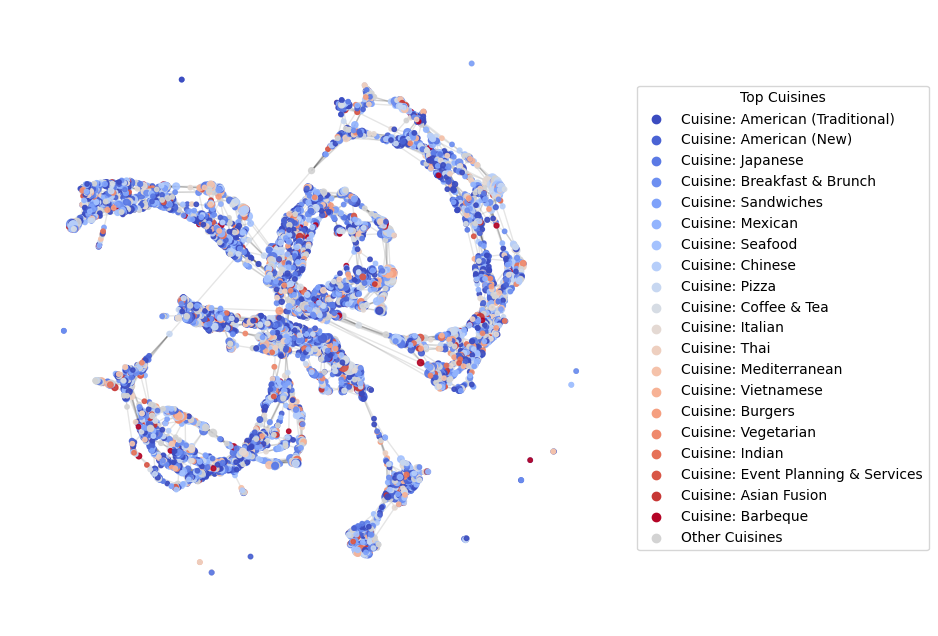

In [31]:
def extract_cuisine_by_weight(categories, category_weights):
    ignore_list = {"Restaurants", "Food", "Nightlife", "Bars"}
    if isinstance(categories, str):
        categories = categories.split(", ")
    valid_categories = [category for category in categories if category not in ignore_list]
    if valid_categories:
        return max(valid_categories, key=lambda c: category_weights.get(c, 0))
    return "Unknown"

category_weights = calculate_category_weights(G)

filtered_reviews_for_graph['cuisine'] = filtered_reviews_for_graph['categories'].apply(
    lambda x: extract_cuisine_by_weight(x, category_weights)
)

business_to_cuisine = dict(zip(filtered_reviews_for_graph['business_id'], filtered_reviews_for_graph['cuisine']))
nx.set_node_attributes(G, business_to_cuisine, "cuisine")

G.remove_edges_from(nx.selfloop_edges(G))
G.remove_nodes_from(list(nx.isolates(G)))

forceatlas2 = ForceAtlas2(
    outboundAttractionDistribution=True,
    linLogMode=False,
    adjustSizes=False,
    edgeWeightInfluence=1.0,
    jitterTolerance=1.0,
    barnesHutOptimize=True,
    barnesHutTheta=1.2,
    scalingRatio=2.0,
    strongGravityMode=False,
    gravity=20.0,
    verbose=True
)
# Uncomment this if you need to recalculate positions
# positions = forceatlas2.forceatlas2_networkx_layout(G, iterations=2000)

cuisine_clusters = defaultdict(list)
for node, data in G.nodes(data=True):
    cuisine = data.get("cuisine")
    if cuisine:
        cuisine_clusters[cuisine].append(node)

communities = [set(nodes) for nodes in cuisine_clusters.values()]

cuisine_sizes = {cuisine: len(nodes) for cuisine, nodes in cuisine_clusters.items()}
sorted_cuisines = sorted(cuisine_sizes.items(), key=lambda x: x[1], reverse=True)

top_cuisines = {cuisine: i for i, (cuisine, size) in enumerate(sorted_cuisines[:20])}

colors = plt.cm.get_cmap('coolwarm', len(top_cuisines))
node_colors = []

for node in G.nodes():
    cuisine = G.nodes[node].get("cuisine")
    if cuisine in top_cuisines:
        node_colors.append(colors(top_cuisines[cuisine]))
    else:
        node_colors.append('lightgray')

node_sizes = [max(len(G[node]) * 2, 10) for node in G.nodes()]

plt.figure(figsize=(8, 8))

nx.draw_networkx_nodes(
    G, positions,
    node_size=node_sizes,
    node_color=node_colors,
    cmap=plt.cm.coolwarm,
    alpha=0.9
)

nx.draw_networkx_edges(
    G, positions,
    edge_color='black',
    alpha=0.1
)

for cuisine, idx in top_cuisines.items():
    plt.scatter([], [], c=[colors(idx)], label=f"Cuisine: {cuisine}")

plt.scatter([], [], c='lightgray', label="Other Cuisines")

plt.legend(
    title="Top Cuisines",
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    frameon=True
)

plt.axis('off')
plt.savefig("cuisines_weighted.png", format="png", dpi=600, bbox_inches='tight')
plt.show()

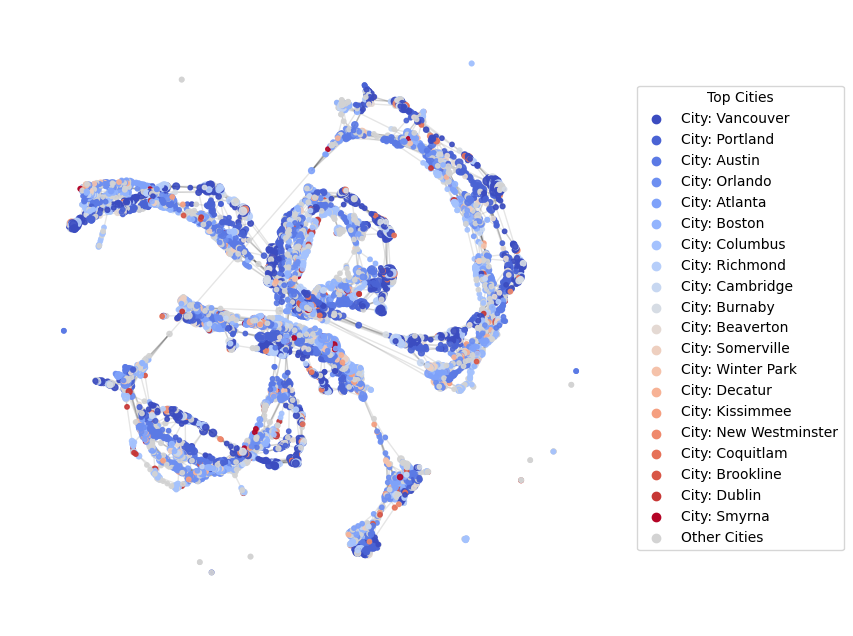

In [32]:
G.remove_edges_from(nx.selfloop_edges(G))
G.remove_nodes_from(list(nx.isolates(G)))

forceatlas2 = ForceAtlas2(
    outboundAttractionDistribution=True,
    linLogMode=False,
    adjustSizes=False,
    edgeWeightInfluence=1.0,
    jitterTolerance=1.0,
    barnesHutOptimize=True,
    barnesHutTheta=1.2,
    scalingRatio=2.0,
    strongGravityMode=False,
    gravity=20.0,
    verbose=True
)
#positions = forceatlas2.forceatlas2_networkx_layout(G, iterations=2000)

business_to_city = dict(zip(filtered_reviews_for_graph['business_id'], filtered_reviews_for_graph['city']))
nx.set_node_attributes(G, business_to_city, "city")

city_clusters = defaultdict(list)
for node, data in G.nodes(data=True):
    city = data.get("city", "Unknown")
    city_clusters[city].append(node)

communities = [set(nodes) for nodes in city_clusters.values()]

city_sizes = {city: len(nodes) for city, nodes in city_clusters.items()}
sorted_cities = sorted(city_sizes.items(), key=lambda x: x[1], reverse=True)

top_cities = {city: i for i, (city, size) in enumerate(sorted_cities[:20])}

colors = plt.cm.get_cmap('coolwarm', len(top_cities))
node_colors = []

for node in G.nodes():
    city = G.nodes[node].get("city", "Unknown")
    if city in top_cities:
        node_colors.append(colors(top_cities[city]))
    else:
        node_colors.append('lightgray')

node_degree = dict(G.degree())
node_sizes = [max(node_degree[node] * 2, 10) for node in G.nodes()]

plt.figure(figsize=(8, 8))

nx.draw_networkx_nodes(
    G, positions,
    node_size=node_sizes,
    node_color=node_colors,
    cmap=plt.cm.coolwarm,
    alpha=0.9
)

nx.draw_networkx_edges(
    G, positions,
    edge_color='black',
    alpha=0.1
)

for city, idx in top_cities.items():
    plt.scatter([], [], c=[colors(idx)], label=f"City: {city}")

plt.scatter([], [], c='lightgray', label="Other Cities")

plt.legend(
    title="Top Cities",
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    frameon=True
)

plt.axis('off')
#plt.title("Network Graph by City Communities (Cold to Warm Palette)", fontsize=16)
plt.savefig("cities.png", format="png", dpi=600, bbox_inches='tight')
plt.show()

The three visualizations above show the graph network with the top 20 highlighted communities for each type of clustering (Louvain, cuisines, and cities, respectively). The Louvain clustering provides the most visually distinct groups, which makes sense as the Louvain algorithm is specifically designed to optimize modularity. In the cuisine-based clustering, we notice that the visualization is dominated by shades of blue. This is likely due to our method of extracting cuisines by weighing them and selecting the most common one, which can cause popular cuisines to dominate the network, leaving less common cuisines underrepresented. Similarly, in the city-based clustering, many nodes appear in blue hues, reflecting the dominance of certain cities in the dataset (e.g., Vancouver, Orlando, Portland, etc.). This observation supports the idea that the data collection is biased or lacks variation, as certain cities are overrepresented.

In [34]:
filtered_data_path = 'filtered_reviews_open2018_2019.csv'
filtered_data = pd.read_csv(filtered_data_path)

filtered_data['business_id'] = filtered_data['business_id'].astype(str)

business_to_community = {node: community_id for node, community_id in louvain_partition.items()}

filtered_data['louvain_community'] = filtered_data['business_id'].map(business_to_community)

output_file_path = 'filtered_reviews_with_communities.csv'
filtered_data.to_csv(output_file_path, index=False)

print(f"Updated file with Louvain community numbers saved as: {output_file_path}")

Updated file with Louvain community numbers saved as: filtered_reviews_with_communities.csv


# Sentiment Text Analysis

In this section we will apply the sentiment analysis learned during the course to the restaurant reviwes. By doing this analysis we aim to better understand the data and set the basis for future analysis. We want to find patterns between the sentiment score and different attributes of the data. Ïn order to do the analysis, we will use the text file provided by the course, and previously used in the second assignment.

We will start by loading the filteres csv file and defining the functions that will later be used.

Loading sentiment scores.....

Applying the sentiment calculation.....

Calculating category weights...

Assigning weighted categories...



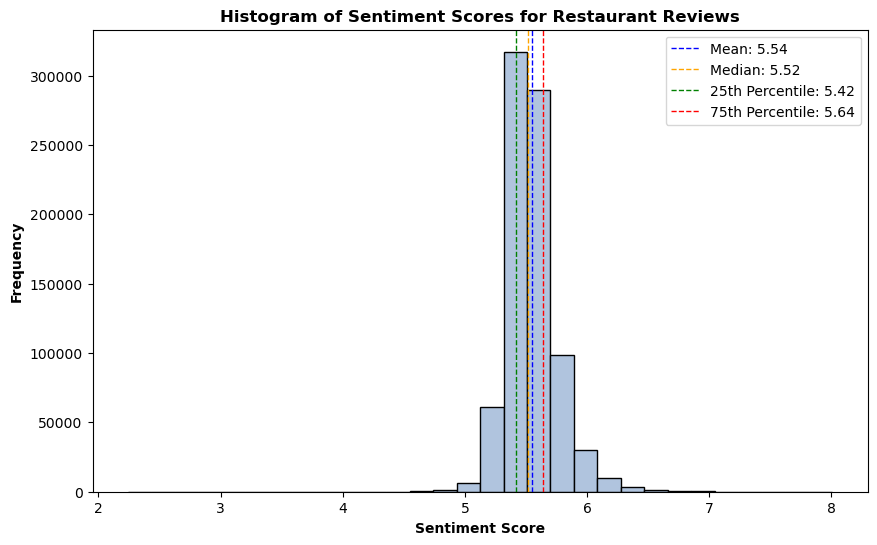

In [3]:
# Load the CSV data
csv_file = 'filtered_reviews_with_communities.csv'
data = pd.read_csv(csv_file)

# Function to load the sentiment scores from the Data_Set_S1.txt file
def load_labmt(file_path):
    labmt_scores = {}
    with open(file_path, 'r') as f:
        lines = f.readlines()
        for line in lines[4:]:
            parts = line.strip().split('\t')
            if len(parts) >= 3:
                word = parts[0]
                happiness_score = parts[2]
                try:
                    labmt_scores[word] = float(happiness_score)
                except ValueError:
                    continue
    return labmt_scores

# Function to calculate sentiment score for each review
def calculate_sentiment(tokens, labmt_scores):
    total_score = 0
    count = 0
    for token in tokens:
        if token in labmt_scores:
            total_score += labmt_scores[token]
            count += 1
    return total_score / count if count > 0 else None

# Load sentiment scores from the Data_Set_S1.txt file
print('Loading sentiment scores.....\n')
labmt_scores = load_labmt("Data_Set_S1.txt")

print('Applying the sentiment calculation.....\n')
# Apply the sentiment calculation to the reviews in the data
data['tokens'] = data['text_'].str.lower().str.split()
data['sentiment_score'] = data['tokens'].apply(lambda x: calculate_sentiment(x, labmt_scores))

# Some rows have nans on the sentiment score, so let's remove those
data = data.dropna(subset=['sentiment_score'])

# Function to calculate category weights
def calculate_category_weights(data):
    category_counts = Counter()
    for categories in data['categories']:
        if isinstance(categories, str):
            category_list = categories.split(", ")
            category_counts.update(category_list)
    return dict(category_counts)

# Calculate weights for each category
print('Calculating category weights...\n')
category_weights = calculate_category_weights(data)

# Assign the highest-weighted category to each row
def assign_weighted_category(categories, weights):
    if isinstance(categories, str):
        category_list = categories.split(", ")
        # Exclude ignored categories and pick the highest-weighted one
        ignore_list = {"Restaurants", "Food", "Nightlife", "Bars"}
        valid_categories = [c for c in category_list if c not in ignore_list]
        if valid_categories:
            return max(valid_categories, key=lambda c: weights.get(c, 0))
    return "Unknown"

print('Assigning weighted categories...\n')
data['weighted_category'] = data['categories'].apply(lambda x: assign_weighted_category(x, category_weights))

# Calculate sentiment statistics
sentiment_values = data['sentiment_score'].dropna().values
mean_sentiment = np.mean(sentiment_values)
median_sentiment = np.median(sentiment_values)
variance_sentiment = np.var(sentiment_values)
percentile_25 = np.percentile(sentiment_values, 25)
percentile_75 = np.percentile(sentiment_values, 75)

# Plot histogram of sentiment scores
plt.figure(figsize=(10, 6))
plt.hist(sentiment_values, bins=30, edgecolor='black', color='lightsteelblue')
plt.axvline(mean_sentiment, color='blue', linestyle='dashed', linewidth=1, label=f'Mean: {mean_sentiment:.2f}')
plt.axvline(median_sentiment, color='orange', linestyle='dashed', linewidth=1, label=f'Median: {median_sentiment:.2f}')
plt.axvline(percentile_25, color='green', linestyle='dashed', linewidth=1, label=f'25th Percentile: {percentile_25:.2f}')
plt.axvline(percentile_75, color='red', linestyle='dashed', linewidth=1, label=f'75th Percentile: {percentile_75:.2f}')
plt.legend()
plt.title("Histogram of Sentiment Scores for Restaurant Reviews", fontweight='bold')
plt.xlabel("Sentiment Score", fontweight='bold')
plt.ylabel("Frequency", fontweight='bold')
plt.show()

As it can be seen on the graph, the scores are centered at 5.5 and have quite a low standard deviation, which shows that most restaurants have an average quality (according only to reviews, of course). The best results of the sentiment analysis reach the value of 8, and the minimum is 4.5. It is worth mentioning that the maximum and minimum results will not be as present in the future discussion, since the different restaurants will be analyzed on average, and these are scores for individual reviews (so a very happy or unhappy customer on a specific day).

In [4]:
grouped_data = data[['business_id', 'sentiment_score']].groupby('business_id').mean()
merged_data = grouped_data.merge(data[['business_id', 'name']].drop_duplicates(), on='business_id')
sorted_data = merged_data.sort_values('sentiment_score', ascending=False)

# Display the top 10 happiest and saddest restaurants
print("\nTop 10 Happiest Restaurants:")
print(sorted_data[['name', 'sentiment_score']].head(10))

print("\nTop 10 Saddest Restaurants:")
print(sorted_data[['name', 'sentiment_score']].tail(10))


Top 10 Happiest Restaurants:
                                 name  sentiment_score
3697                       Come Arepa         5.921039
6217                   Take Five Cafe         5.853811
3300            Hideaway Eatery & Bar         5.803832
8249            Favela Brazilian Cafe         5.791679
5559        Sahel Market & Restaurant         5.782440
7076           Caravan Authentic Cafe         5.765982
181   Thornton Family Coffee Roasters         5.765875
1965          Nana's Guilty Pleasures         5.760454
557                  Incognito Coffee         5.748815
5447                    Hi-Top Tavern         5.748191

Top 10 Saddest Restaurants:
                        name  sentiment_score
2040              McDonald's         5.309183
3527  Chipotle Mexican Grill         5.308950
4031         Anna's Taqueria         5.308415
3339             Burger King         5.307414
2990                    Wawa         5.304107
8473  Chipotle Mexican Grill         5.301598
3073      Wave

This print displays the top 10 and bottom 10 restaurants based on sentiment scores. It is important to take into account, if we look at the code, we are grouping by business_id, but displaying the name. We are doing it this way because there are some restaurants that have different business_id but the same name (for example a McDonald's franchise) and we want the scores of the individual restaurants.

In [17]:
# Group by weighted category and calculate statistics
weighted_category_sentiment = data.groupby('weighted_category').agg(
    count=('business_id', 'nunique'),
    sentiment_score=('sentiment_score', 'mean'),
    sentiment_score_sd=('sentiment_score', 'std')
).reset_index()


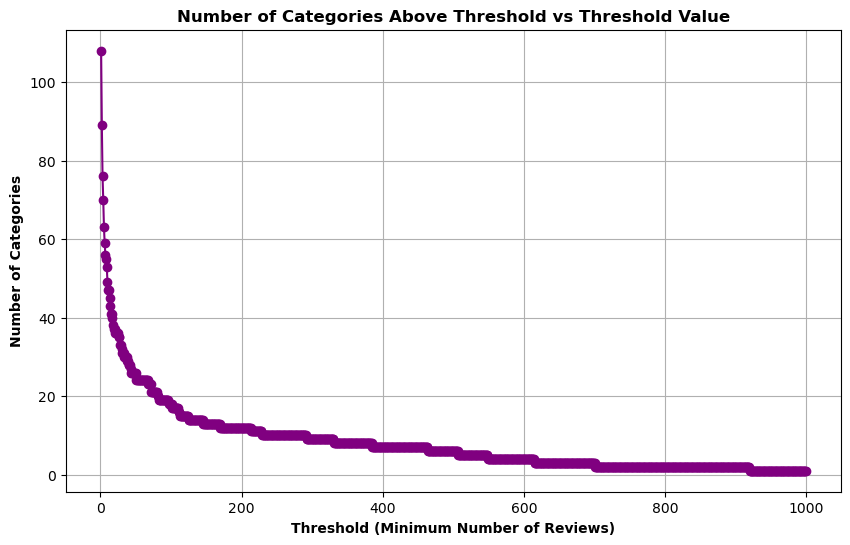

In [18]:
# Set the threshold range (you can modify this as needed)
threshold_range = range(1, 1000)

# List to store the number of categories above each threshold
num_categories = []

# Loop through thresholds and count categories that meet the condition
for threshold in threshold_range:
    # Filter the categories with count >= threshold
    filtered_categories = weighted_category_sentiment[weighted_category_sentiment['count'] >= threshold]
    
    # Append the number of categories to the list
    num_categories.append(len(filtered_categories))

# Plot the number of categories vs threshold
plt.figure(figsize=(10, 6))
plt.plot(threshold_range, num_categories, marker='o', linestyle='-', color='purple')
plt.title("Number of Categories Above Threshold vs Threshold Value", fontweight='bold')
plt.xlabel("Threshold (Minimum Number of Reviews)", fontweight='bold')
plt.ylabel("Number of Categories", fontweight='bold')
plt.grid(True)
plt.show()

In [ ]:
threshold = 200
filtered_categories = weighted_category_sentiment[weighted_category_sentiment['count'] >= threshold]
sorted_data = filtered_categories.sort_values('sentiment_score', ascending=False)

print("\nTop 10 Happiest Categories:")
print(sorted_data.head(10))

print("\nTop 10 Saddest Categories:")
print(sorted_data.tail(10))

#%% LaTeX Table Generation for Top and Bottom 10
for i in range(10):
    print(f"{i+1} & {sorted_data.iloc[i]['weighted_category']} & {sorted_data.iloc[i]['sentiment_score']:.3f} & {i+1} & {sorted_data.iloc[-(i+1)]['weighted_category']} & {sorted_data.iloc[-(i+1)]['sentiment_score']:.3f} \\\ \hline")


Top 10 Happiest Categories:
      weighted_category  count  sentiment_score  sentiment_score_sd
105          Vegetarian    101         5.575948            0.213681
83                Salad    110         5.573904            0.210363
100                Thai    124         5.559573            0.202277
61              Italian    384         5.559559            0.209928
78                Pizza    169         5.557608            0.209495
28         Coffee & Tea    291         5.555961            0.199058
14   Breakfast & Brunch    919         5.554690            0.208430
2        American (New)   1282         5.553459            0.205491
27        Cocktail Bars    228         5.552035            0.202228
6          Asian Fusion    213         5.544934            0.201008

Top 10 Saddest Categories:
            weighted_category  count  sentiment_score  sentiment_score_sd
27              Cocktail Bars    228         5.552035            0.202228
6                Asian Fusion    213         5.

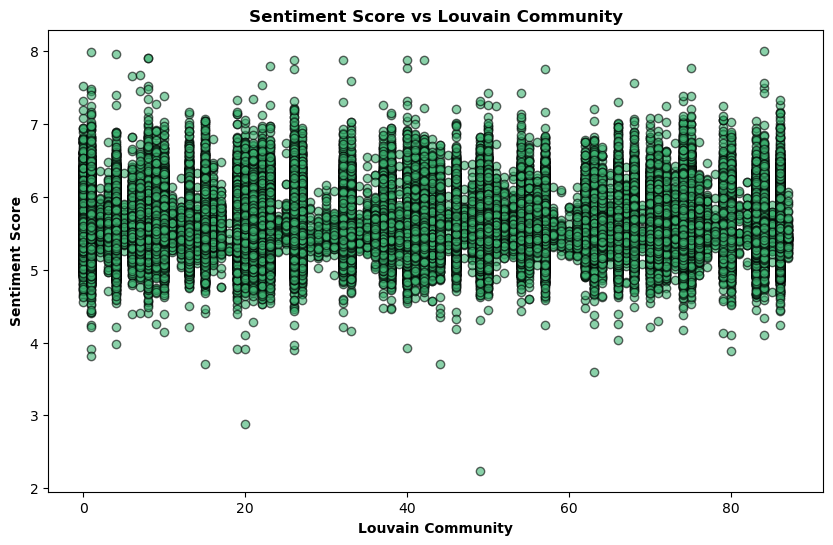

Correlation between sentiment score and louvain community: 0.00


In [41]:
# Scatter plot for sentiment score and louvain_community
plt.figure(figsize=(10, 6))
plt.scatter(data['louvain_community'], data['sentiment_score'], alpha=0.6, color='mediumseagreen', edgecolor='black')
plt.title("Sentiment Score vs Louvain Community", fontweight='bold')
plt.xlabel("Louvain Community", fontweight='bold')
plt.ylabel("Sentiment Score", fontweight='bold')
plt.show()

# Calculate the correlation between sentiment score and louvain_community
correlation = data[['louvain_community', 'sentiment_score']].corr().iloc[0, 1]
print(f"Correlation between sentiment score and louvain community: {correlation:.2f}")

In [42]:
cuisines_wiki = cuisine_scrap()
distinct_categories = list(data_expanded['categories'].unique())

count = 0
for category in distinct_categories:
    if category.lower() in cuisines_wiki or category.lower() + ' cuisine' in cuisines_wiki:
        count += 1
        
print(f'Cuisines inside the wiki: {count}/{len(distinct_categories)}')

Cuisines inside the wiki: 65/674


In [43]:
grouped_data = data[['postal_code', 'sentiment_score']].groupby('postal_code').mean()
sorted_data = grouped_data.sort_values('sentiment_score', ascending=False)

# Display the top 10 happiest and saddest restaurants
print("\nTop 10 Happiest Restaurants:")
print(sorted_data['sentiment_score'].head(10))

print("\nTop 10 Saddest Restaurants:")
print(sorted_data['sentiment_score'].tail(10))


Top 10 Happiest Restaurants:
postal_code
V4C 6R9    6.074545
V3W 8J9    5.991429
V7H 0A6    5.960000
V3T 1W2    5.947761
V3H 5B7    5.939155
V7H 1A6    5.899020
V6B 3M4    5.874167
34734      5.873395
V5K 1Y6    5.865145
V3J 1N8    5.862290
Name: sentiment_score, dtype: float64

Top 10 Saddest Restaurants:
postal_code
32955      5.219763
V5T 1W2    5.219583
V6Z 1K7    5.211545
V5N 1W3    5.210913
V6X 1L6    5.204118
V3T 2X2    5.175263
V3B 0C4    5.171600
V7B 1K7    5.166047
V6R 2B2    5.108674
V5Z 2W7    5.071429
Name: sentiment_score, dtype: float64


In [44]:
# Group by 'postal_code' and calculate the average sentiment score
grouped_data = data[['postal_code', 'sentiment_score']].groupby('postal_code').mean()

# Merge with original data to get 'latitude', 'longitude' for each postal_code
# We assume the latitude and longitude are the same for each postal code
grouped_with_coords = grouped_data.merge(
    data[['postal_code', 'latitude', 'longitude']].drop_duplicates(), 
    on='postal_code'
)

# Normalize the sentiment scores between 0 and 1 for color mapping
min_score = grouped_with_coords['sentiment_score'].min()
max_score = grouped_with_coords['sentiment_score'].max()
grouped_with_coords['normalized_score'] = (grouped_with_coords['sentiment_score'] - min_score) / (max_score - min_score)

# Function to map the normalized sentiment score to a color (green to red)
cmap = matplotlib.cm.get_cmap('RdYlGn')  # Red to Green colormap

def sentiment_to_color(normalized_score):
    # Convert normalized score to RGB and then to hex
    color = cmap(normalized_score)
    return matplotlib.colors.rgb2hex(color[:3])

# Create a map centered at an average location (mean of latitudes and longitudes)
mean_latitude = data['latitude'].mean()
mean_longitude = data['longitude'].mean()
m = folium.Map(location=[mean_latitude, mean_longitude], zoom_start=2)

# Add circle markers for each postal code with color based on average sentiment score
for _, row in grouped_with_coords.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5,  # Set a suitable radius for visibility
        color=sentiment_to_color(row['normalized_score']),
        fill=True,
        fill_color=sentiment_to_color(row['normalized_score']),
        fill_opacity=0.7,  # Adjust opacity for better visibility
        popup=f"Postal Code: {row['postal_code']}\nAverage Sentiment Score: {row['sentiment_score']:.2f}"
    ).add_to(m)

# Save the map to an HTML file and display it
#m.save('postal_code_sentiment_map_simple.html')
#m

In [45]:
# Group by 'business_id' and calculate the average sentiment score
grouped_data = data[['business_id', 'sentiment_score']].groupby('business_id').mean()

# Merge with original data to get 'latitude', 'longitude', and 'name'
grouped_with_coords = grouped_data.merge(
    data[['business_id', 'latitude', 'longitude', 'name']].drop_duplicates(), 
    on='business_id'
)

# Normalize the sentiment scores between 0 and 1 for color mapping
min_score = grouped_with_coords['sentiment_score'].min()
max_score = grouped_with_coords['sentiment_score'].max()
grouped_with_coords['normalized_score'] = (grouped_with_coords['sentiment_score'] - min_score) / (max_score - min_score)

# Function to map the normalized sentiment score to a color (green to red)
cmap = matplotlib.cm.get_cmap('RdYlGn')  # Red to Green colormap

def sentiment_to_color(normalized_score):
    # Convert normalized score to RGB and then to hex
    color = cmap(normalized_score)
    return matplotlib.colors.rgb2hex(color[:3])

# Create a map centered at an average location (mean of latitudes and longitudes)
mean_latitude = data['latitude'].mean()
mean_longitude = data['longitude'].mean()
m = folium.Map(location=[mean_latitude, mean_longitude], zoom_start=2)

# Add markers for each restaurant with color based on sentiment score
for _, row in grouped_with_coords.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f"Name: {row['name']}\nSentiment Score: {row['sentiment_score']:.2f}",
        icon=folium.Icon(color='white', icon_color=sentiment_to_color(row['normalized_score']), icon='info-sign')
    ).add_to(m)

# Save the map to an HTML file and display it
#m.save('all_restaurants_sentiment_map.html')
#m

In [46]:
# Group by postal_code and calculate mean sentiment_score
grouped_data = data[['postal_code', 'sentiment_score']].groupby('postal_code').mean()
sorted_data = grouped_data.sort_values('sentiment_score', ascending=False)

# Get the top 10 happiest and saddest postal codes
happiest = sorted_data.head(10)
saddest = sorted_data.tail(10)

# Merge to get latitude and longitude for the happiest and saddest
happiest_with_coords = happiest.merge(data[['postal_code', 'latitude', 'longitude']].drop_duplicates(), on='postal_code')
saddest_with_coords = saddest.merge(data[['postal_code', 'latitude', 'longitude']].drop_duplicates(), on='postal_code')

# Create a map centered at an average location (mean of latitudes and longitudes)
mean_latitude = data['latitude'].mean()
mean_longitude = data['longitude'].mean()
m = folium.Map(location=[mean_latitude, mean_longitude], zoom_start=2)

# Add markers for the top 10 happiest restaurants
for _, row in happiest_with_coords.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f"Postal Code: {row['postal_code']}\nSentiment Score: {row['sentiment_score']:.2f}",
        icon=folium.Icon(color='green')
    ).add_to(m)

# Add markers for the top 10 saddest restaurants
for _, row in saddest_with_coords.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f"Postal Code: {row['postal_code']}\nSentiment Score: {row['sentiment_score']:.2f}",
        icon=folium.Icon(color='red')
    ).add_to(m)

# Save the map to an HTML file and display it
#m.save('happiest_saddest_restaurants_map.html')
#m

In [47]:
# Saving the DataFrame for use in the next part
data.to_csv("data.csv", index=False) 

# Combining Community Analysis with Sentiment Scores

For this part we will investigate if there are any sentiment trends within and across the different communities (Louvain, city-based, and cuisine-based). 

We start by adding a weight attribute to each edge, which is the average sentiment score of the two businesses it connects - This metric is needed to later calculate the internal and external sentiment for the communities.

In [48]:
pickle_file_name = "business_graph_with_filtered_attributes.pkl"
with open(pickle_file_name, 'rb') as file:
    G = pickle.load(file)

# Loading the sentiment scores from the CSV
csv_file = "data.csv"
reviews_df = pd.read_csv(csv_file)

# Computing the average sentiment score for each business
business_sentiments = reviews_df.groupby('business_id')['sentiment_score'].mean().to_dict()

# Adding the edge weights in the graph
for u, v in G.edges():
    # Getting the sentiment scores for two connected businesses
    score_u = business_sentiments.get(u, 0)  
    score_v = business_sentiments.get(v, 0)

    # Computing the edge weight as the average of the two businesses' sentiment scores
    G[u][v]['weight'] = (score_u + score_v) / 2

Now that we have the weight attributes we start by looking at the internal sentiment for each community. The internal sentiment scores measure how positively or negatively businesses within the same community are connected through reviews. 

To do so, we first need to define a few functions to ease the process of computing the results of all three community types (Louvain, City and Category). 

In [49]:
# Function for calculating internal and external sentiments for any community type
def calculate_internal_external_sentiments(graph, communities):
    community_sentiments = {}

    for community, nodes in communities.items():
        internal_sentiments = []
        external_sentiments = []

        for u, v, data in graph.edges(data=True):
            if u in nodes and v in nodes:
                # Internal edge if both nodes are in the same community
                internal_sentiments.append(data.get('weight', 0))
            elif (u in nodes and v not in nodes) or (v in nodes and u not in nodes):
                # External edge if one node is in the community and the other is not
                external_sentiments.append(data.get('weight', 0))

        community_sentiments[community] = {
            'internal_avg': sum(internal_sentiments) / len(internal_sentiments) if internal_sentiments else 0,
            'external_avg': sum(external_sentiments) / len(external_sentiments) if external_sentiments else 0
        }

    return community_sentiments

In [50]:
# Function for creating attribute-based communities
def calculate_attribute_communities(graph, attribute):
    attribute_communities = {}
    for node, data in graph.nodes(data=True):
        attr_value = data.get(attribute, 'Unknown')
        if attr_value not in attribute_communities:
            attribute_communities[attr_value] = []
        attribute_communities[attr_value].append(node)
    return attribute_communities

In [51]:
# Function for filtering out communities with no internal sentiment scores
def filter_empty_communities(sentiments):
    return {k: v for k, v in sentiments.items() if v['internal_avg'] > 0 or v['external_avg'] > 0}

In [52]:
# Function for visualization of top and bottom communities
def plot_top_bottom(data, title, xlabel, ylabel, top_n=10):
    sorted_data = pd.Series(data).sort_values()
    bottom = sorted_data.head(top_n)
    top = sorted_data.tail(top_n)
    top_bottom = pd.concat([bottom, top])

    ax = top_bottom.plot(kind='bar', figsize=(12, 6))
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=45, ha='right')

    # Added shade to background to distinguish bottom and top communities
    ax.axvspan(-0.5, len(bottom) - 0.5, color='red', alpha=0.1, label='Bottom Communities')
    ax.axvspan(len(bottom) - 0.5, len(bottom) + len(top) - 0.5, color='green', alpha=0.1, label='Top Communities')

    # Added legends for shaded areas
    ax.legend(["Bottom Communities", "Top Communities"])

    plt.show()

Now we can apply the functions to the communities. 

In [53]:
# Louvain-based communities
louvain_communities = nx.get_node_attributes(G, 'louvain_community')
louvain_sentiments = calculate_internal_external_sentiments(
    G, {k: [node for node, v in louvain_communities.items() if v == k] for k in set(louvain_communities.values())}
)

louvain_sentiments = filter_empty_communities(louvain_sentiments)

# Attribute-based communities
city_communities = calculate_attribute_communities(G, 'city')
category_communities = calculate_attribute_communities(G, 'categories')

# Sentiments for city and category communities
city_sentiments = calculate_internal_external_sentiments(G, city_communities)
category_sentiments = calculate_internal_external_sentiments(G, category_communities)

city_sentiments = filter_empty_communities(city_sentiments)
category_sentiments = filter_empty_communities(category_sentiments)

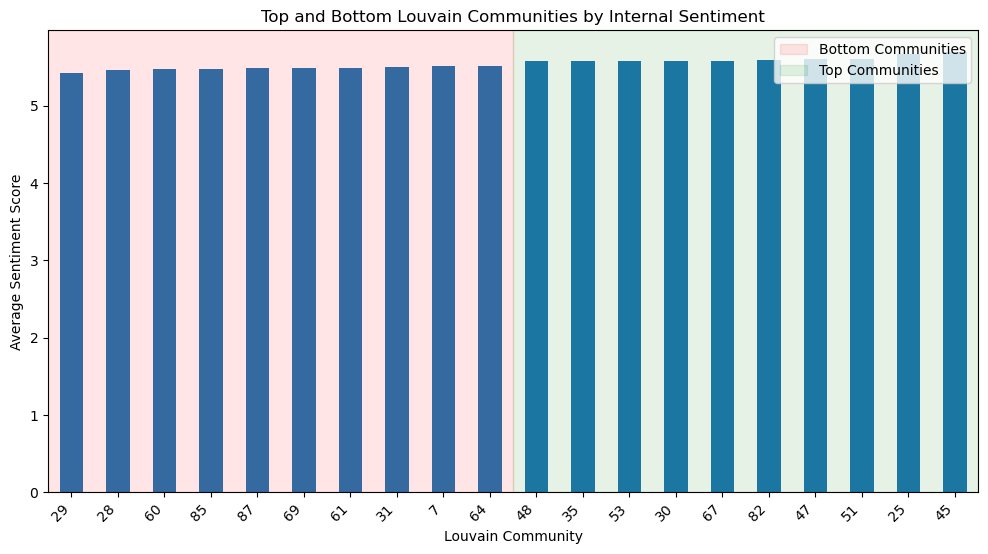

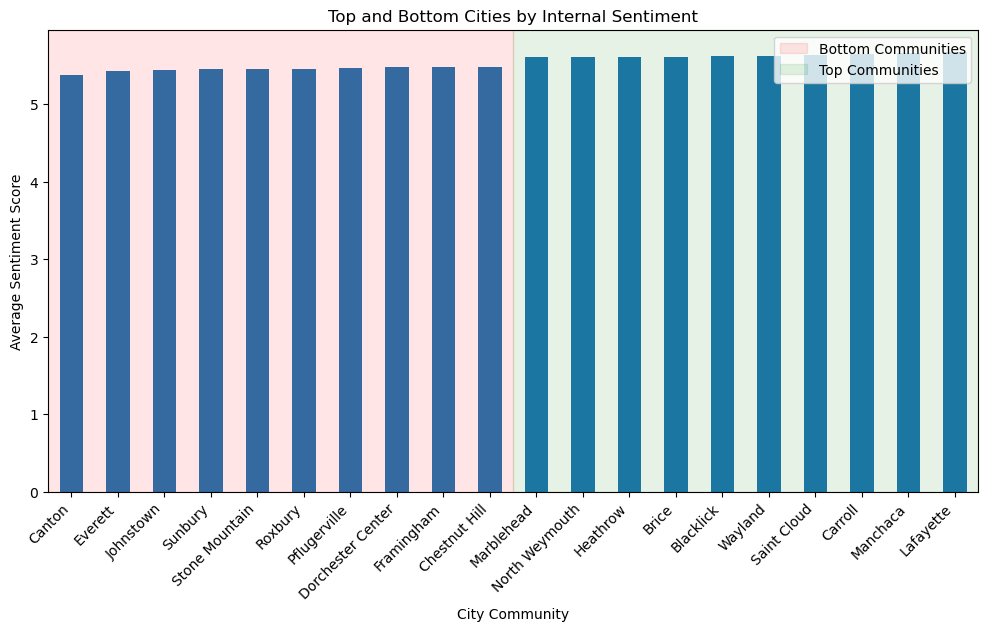

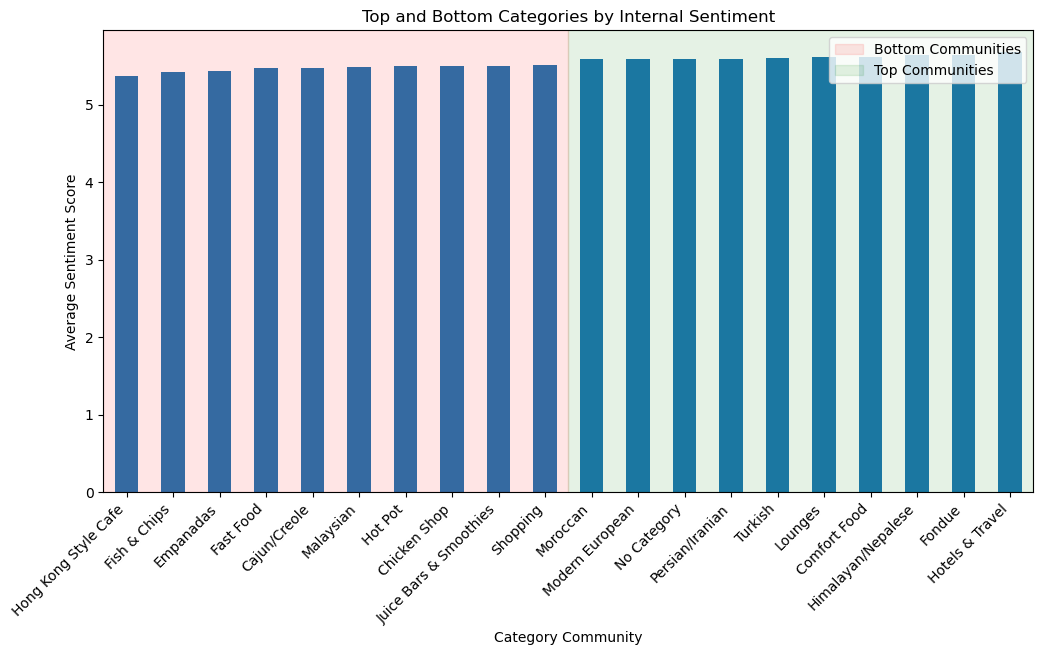

In [54]:
# Visualizations
plot_top_bottom(
    {k: v['internal_avg'] for k, v in louvain_sentiments.items() if v['internal_avg'] > 0},
    "Top and Bottom Louvain Communities by Internal Sentiment",
    "Louvain Community",
    "Average Sentiment Score"
)
plot_top_bottom(
    {k: v['internal_avg'] for k, v in city_sentiments.items() if v['internal_avg'] > 0},
    "Top and Bottom Cities by Internal Sentiment",
    "City Community",
    "Average Sentiment Score"
)
plot_top_bottom(
    {k: v['internal_avg'] for k, v in category_sentiments.items() if v['internal_avg'] > 0},
    "Top and Bottom Categories by Internal Sentiment",
    "Category Community",
    "Average Sentiment Score"
)

The internal sentiment plots for Louvain, city-based, and category-based communities show that sentiment scores are pretty much uniform across both the top and bottom communities. There isn’t a lot of difference between the highest and lowest average scores, which suggests that reviewers generally feel the same level of satisfaction regardless of the community.

This consistency means that while the community types (like cities or categories) give us different ways to group the data, the actual sentiment doesn’t vary much between them. To find more meaningful patterns, it might be helpful to dig deeper into things like external sentiment or do some statistical tests. 

Now we move on to look at the Internal and External Sentiments for each community. For this we need to implement a function for plotting. 

In [55]:
def plot_top_bottom_internal_external(sentiments, title, xlabel, ylabel, top_n=10):
    sorted_data = pd.DataFrame(sentiments).T[['internal_avg', 'external_avg']].sort_values(by='internal_avg')
    bottom = sorted_data.head(top_n)
    top = sorted_data.tail(top_n)
    top_bottom = pd.concat([bottom, top])

    ax = top_bottom.plot(kind='bar', figsize=(12, 6))
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(["Internal Sentiment", "External Sentiment"])
    plt.xticks(rotation=45, ha='right')

    # Added shades to background
    ax.axvspan(-0.5, len(bottom) - 0.5, color='red', alpha=0.1, label='Bottom Communities')
    ax.axvspan(len(bottom) - 0.5, len(bottom) + len(top) - 0.5, color='green', alpha=0.1, label='Top Communities')

    # Added legend for shaded areas
    ax.legend(["Bottom Communities", "Top Communities", "Internal Sentiment", "External Sentiment"])
    plt.show()

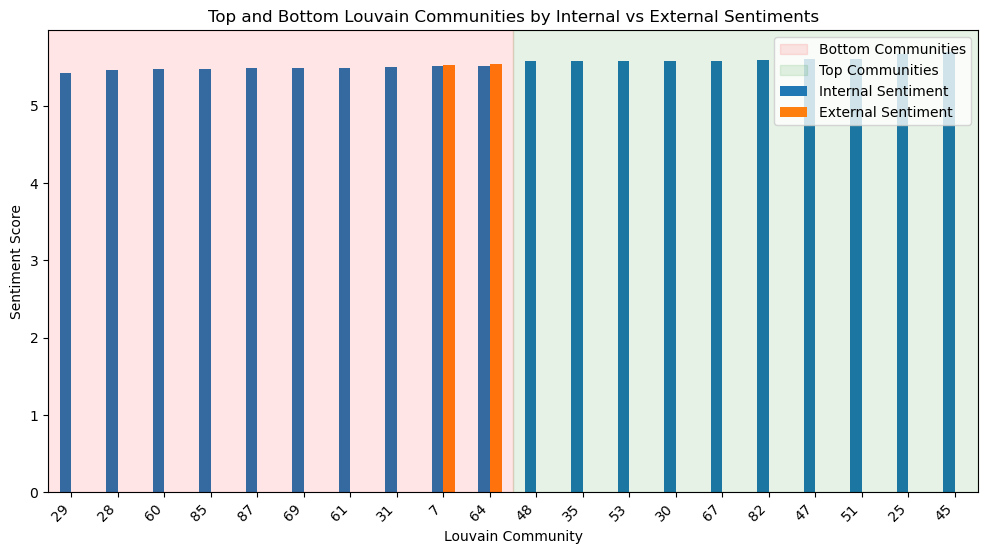

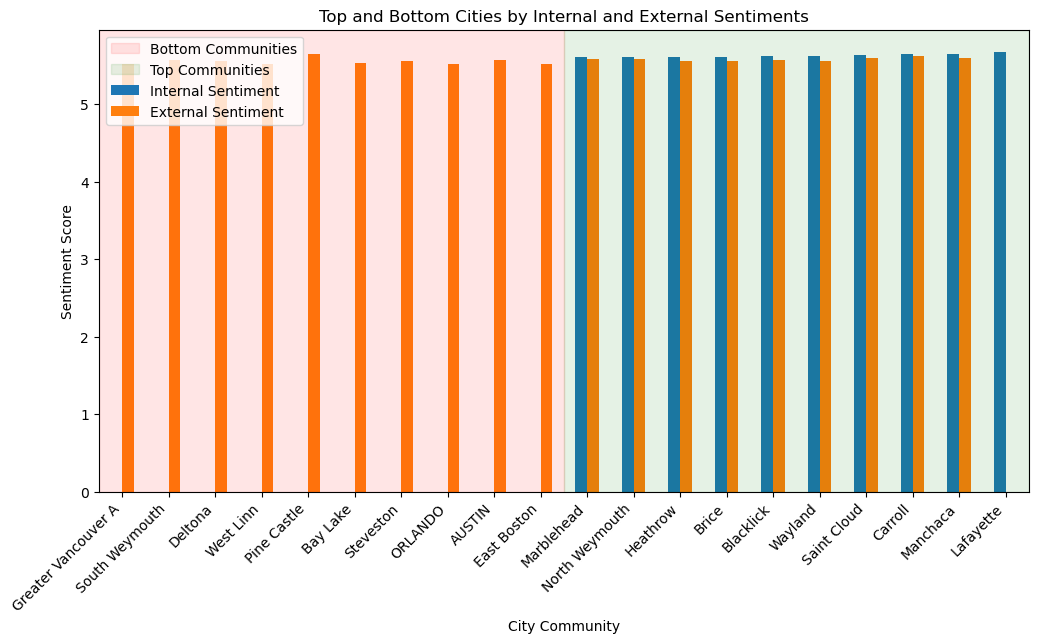

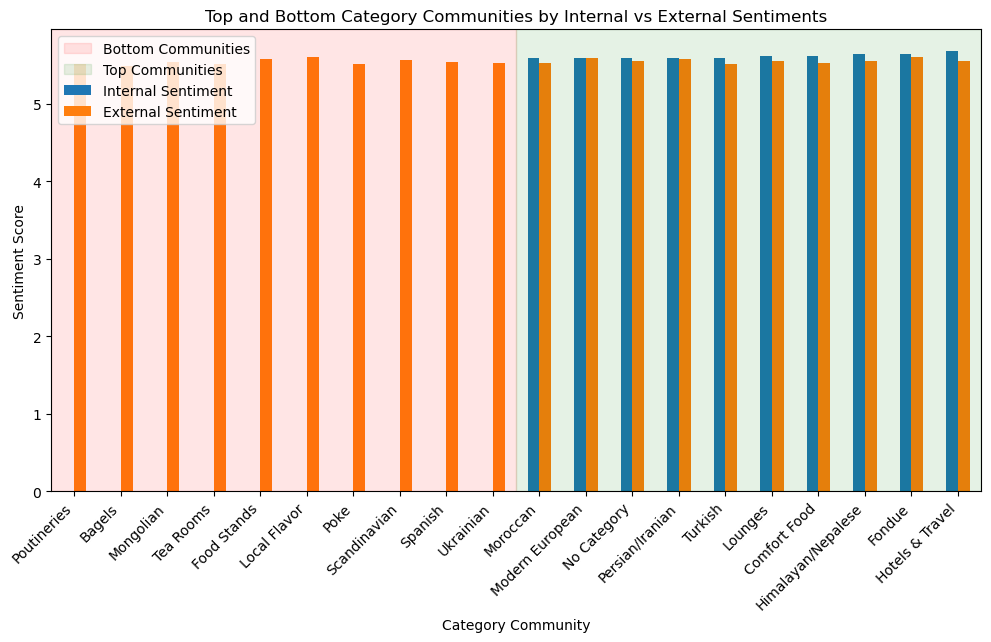

In [56]:
# Internal vs External Sentiment
plot_top_bottom_internal_external(
    louvain_sentiments, 
    "Top and Bottom Louvain Communities by Internal vs External Sentiments", 
    "Louvain Community",
    "Sentiment Score"
)
plot_top_bottom_internal_external(
    city_sentiments,
    "Top and Bottom Cities by Internal and External Sentiments",
    "City Community",
    "Sentiment Score"
)
plot_top_bottom_internal_external(
    category_sentiments, 
    "Top and Bottom Category Communities by Internal vs External Sentiments", 
    "Category Community",
    "Sentiment Score"
)

From the first plot we see that the Louvain Communities mostly consist of internal sentiment scores. This tells us that most of the communities might be more isolated, where all connections are between restaurants within the same community. 
When we on the other hand look at the plot for cities we see that the bottom cities are all external sentiment scores. These cities could be more like hubs, with most of their connections being with restaurants in other cities. This might represent a dining scene that is transient or visitor-heavy, where locals dine out of their city, or where reviewers mostly review businesses elsewhere.
The internal vs external sentiment plot for category communities show how some categories, such as smaller or niche cuisines, tend to have mostly internal sentiment, reflecting tighter, within-category connections. In contrast to broad categories, such as "Diners" or "Hotels & Food", may show more external sentiment, suggesting connections across diverse communities.

And lastly we perform some statistical tests to see if that can further validate our findings. For this we use the Kruskal-Wallis test. As well as plotting the edge weight (sentiment score) ditribution.   

In [57]:
# Function for statistical testing
def perform_statistical_tests(data):
    """Perform Kruskal-Wallis test."""
    flat_data = []
    groups = []
    for group_name, values in data.items():
        flat_data.extend(values)
        groups.extend([group_name] * len(values))
    
    # Kruskal-Wallis test
    stat, p = kruskal(*data.values())
    print(f"Kruskal-Wallis Test: H-statistic = {stat}, p-value = {p}")

perform_statistical_tests({
        "Louvain": [v['internal_avg'] for v in louvain_sentiments.values()],
        "City": [v['internal_avg'] for v in city_sentiments.values()],
        "Category": [v['internal_avg'] for v in category_sentiments.values()]
    })

Kruskal-Wallis Test: H-statistic = 1.1709542160357578, p-value = 0.5568401255361908


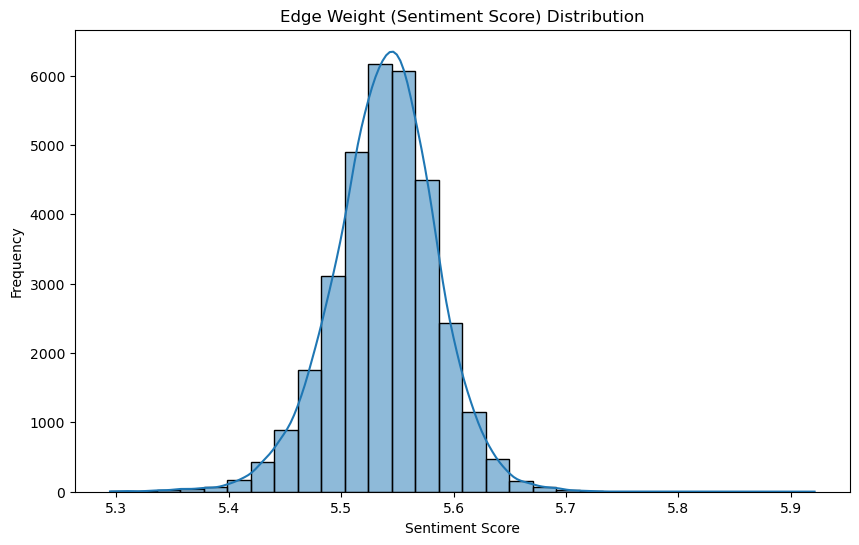

In [58]:
# Function for creating a histogram of edge weight distribution
def analyze_edge_weight_interaction(graph):
    weights = [data['weight'] for _, _, data in graph.edges(data=True)]
    plt.figure(figsize=(10, 6))
    sns.histplot(weights, kde=True, bins=30)
    plt.title("Edge Weight (Sentiment Score) Distribution")
    plt.xlabel("Sentiment Score")
    plt.ylabel("Frequency")
    plt.show()
    
analyze_edge_weight_interaction(G)

The Kruskal-Wallis test with H-statistic = 1.261 and p-value = 0.532 shows no significant differences among internal sentiment scores across the Louvain, city-based, and category-based communities. This would indicate that sentiment is consistently distributed across these groups, which we also saw in some of the earlier findings of consistent satisfaction across the network.

The plot of the distribution of edge weights further shows that the sentiment scores cluster around the mean of 5.5 in a normal-distribution, which justifies that most interactions, so called reviews, are fairly positive. Together, these results show a generally consistent and positive sentiment trend across our network.

# Discussion

This section reflects on what went well and what could have been improved in our project. Overall, we are happy with the amount of work we put into the project and how thoroughly we explored the dataset. We believe the combination of sentiment analysis and network clustering allowed us to approach the data from multiple angles and gave us a solid understanding of its structure.

That said, there is room for improvement. The dataset was massive, and despite spending significant time cleaning it, we still encountered outliers and errors even in the final stages of the project. With more time, we could have refined the cleaning process further to ensure the dataset was fully consistent. Additionally, while our visualizations and analysis covered a lot of ground, incorporating more interactive elements or advanced sentiment modeling might have added an extra layer of depth.

In conclusion, while there are aspects we could improve, we are pleased with the scope and depth of our work and the insights gained from this project.

# Contributions

Daniel Jalel: Responsible for 'Introduction', 'Results' and 'Discussion' regarding clustering and communities and 'Methods'.

Cecilie Bertelsen: Responsible for 'Results' and 'Discussion' on clustering and communities and combining sentiment with communities.

Víctor Cusidó: Responsible for 'Results' and 'Discussion' on sentiment analysis.

All members were responsible for figuring out and coming up with the overall concept and idea of the story.